# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 20 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 20, 20)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(1000, 2, 20, 20)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(1000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(2000, 2, 20, 20)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(2000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 20, 20), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 20

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [39]:
model = Sequential()
model.add(Flatten(input_shape=(2, 20, 20)))
model.add(BatchNormalization())
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(50, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(7))

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 100)               80100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                      

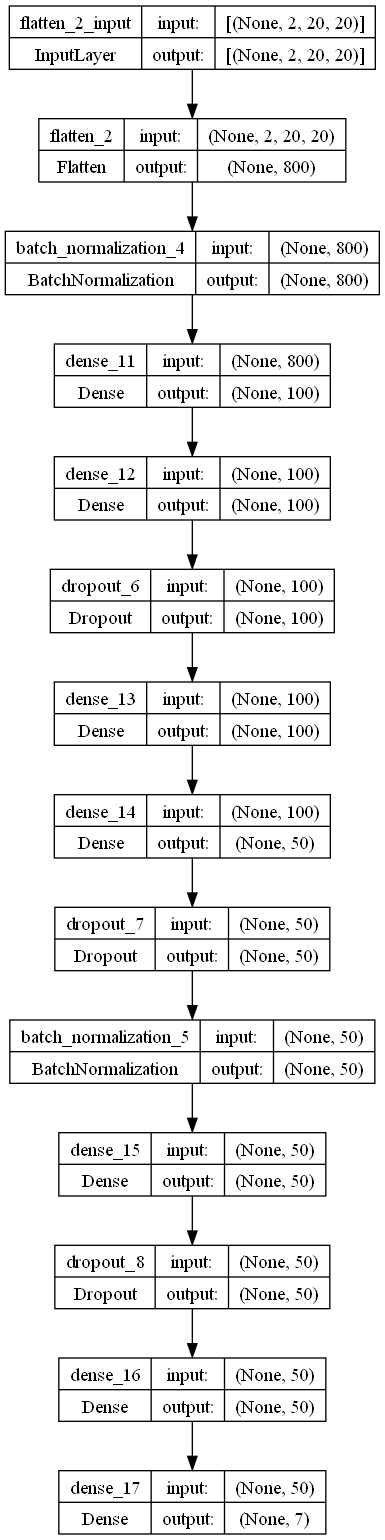

In [41]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [42]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [43]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [44]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [45]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [46]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [47]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
350/350 [==============================] - 1s 2ms/step - loss: 12.4889 - a_1: 2.7887 - a_2: 2.8365 - b_1: 1.9888 - b_2: 2.2030 - d_1: 1.7345 - d_2: 1.6224 - n: 1.6786 - mean_metric: 0.4907 - val_loss: 8.3422 - val_a_1: 2.5826 - val_a_2: 2.5823 - val_b_1: 1.2939 - val_b_2: 1.3451 - val_d_1: 0.7597 - val_d_2: 0.8378 - val_n: 1.4714 - val_mean_metric: 0.3559 - lr: 0.0010
Epoch 2/1000
350/350 [==============================] - 1s 2ms/step - loss: 7.8856 - a_1: 2.3311 - a_2: 2.5889 - b_1: 1.4199 - b_2: 1.5107 - d_1: 1.1809 - d_2: 1.1981 - n: 1.4266 - mean_metric: 0.3853 - val_loss: 6.1614 - val_a_1: 1.9445 - val_a_2: 2.5336 - val_b_1: 1.0453 - val_b_2: 1.2069 - val_d_1: 0.7514 - val_d_2: 0.8403 - val_n: 1.2758 - val_mean_metric: 0.3141 - lr: 0.0010
Epoch 3/1000
350/350 [==============================] - 1s 2ms/step - loss: 6.2880 - a_1: 1.8852 - a_2: 2.3979 - b_1: 1.3544 - b_2: 1.4100 - d_1: 1.1884 - d_2: 1.2235 - n: 1.3540 - mean_metric: 0.3576 - val_loss: 4.5258 - val_a_1: 1.

350/350 [==============================] - 1s 2ms/step - loss: 2.8505 - a_1: 1.5102 - a_2: 1.4784 - b_1: 1.1470 - b_2: 1.1384 - d_1: 0.9927 - d_2: 0.9847 - n: 1.3104 - mean_metric: 0.2832 - val_loss: 1.9687 - val_a_1: 1.1533 - val_a_2: 1.1917 - val_b_1: 0.8057 - val_b_2: 0.7489 - val_d_1: 0.6377 - val_d_2: 0.6623 - val_n: 1.2414 - val_mean_metric: 0.2109 - lr: 0.0010
Epoch 23/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.8012 - a_1: 1.4726 - a_2: 1.4893 - b_1: 1.1311 - b_2: 1.1223 - d_1: 0.9781 - d_2: 0.9646 - n: 1.3066 - mean_metric: 0.2801 - val_loss: 1.9653 - val_a_1: 1.1522 - val_a_2: 1.1309 - val_b_1: 0.7420 - val_b_2: 0.8521 - val_d_1: 0.7558 - val_d_2: 0.5743 - val_n: 1.2239 - val_mean_metric: 0.2106 - lr: 0.0010
Epoch 24/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.7596 - a_1: 1.4755 - a_2: 1.4618 - b_1: 1.0989 - b_2: 1.1142 - d_1: 0.9727 - d_2: 0.9744 - n: 1.3032 - mean_metric: 0.2779 - val_loss: 1.9414 - val_a_1: 1.1447 - val_a

350/350 [==============================] - 1s 2ms/step - loss: 2.5284 - a_1: 1.4208 - a_2: 1.4328 - b_1: 1.0639 - b_2: 1.0842 - d_1: 0.9013 - d_2: 0.9010 - n: 1.2522 - mean_metric: 0.2664 - val_loss: 1.7254 - val_a_1: 1.0992 - val_a_2: 1.0822 - val_b_1: 0.7014 - val_b_2: 0.7287 - val_d_1: 0.7499 - val_d_2: 0.4488 - val_n: 1.1551 - val_mean_metric: 0.1954 - lr: 0.0010
Epoch 44/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.5120 - a_1: 1.4099 - a_2: 1.4341 - b_1: 1.0834 - b_2: 1.0641 - d_1: 0.9056 - d_2: 0.8975 - n: 1.2425 - mean_metric: 0.2658 - val_loss: 1.7165 - val_a_1: 1.0402 - val_a_2: 1.1187 - val_b_1: 0.7569 - val_b_2: 0.7628 - val_d_1: 0.5508 - val_d_2: 0.5029 - val_n: 1.1428 - val_mean_metric: 0.1924 - lr: 0.0010
Epoch 45/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.5122 - a_1: 1.4106 - a_2: 1.4164 - b_1: 1.0926 - b_2: 1.0875 - d_1: 0.8621 - d_2: 0.8941 - n: 1.2383 - mean_metric: 0.2646 - val_loss: 1.6800 - val_a_1: 1.0409 - val_a

350/350 [==============================] - 1s 2ms/step - loss: 2.4096 - a_1: 1.4015 - a_2: 1.3894 - b_1: 1.0235 - b_2: 1.0514 - d_1: 0.8684 - d_2: 0.8730 - n: 1.2055 - mean_metric: 0.2584 - val_loss: 1.5806 - val_a_1: 1.0154 - val_a_2: 1.0345 - val_b_1: 0.6570 - val_b_2: 0.6310 - val_d_1: 0.7186 - val_d_2: 0.4530 - val_n: 1.0801 - val_mean_metric: 0.1830 - lr: 0.0010
Epoch 65/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.4062 - a_1: 1.3617 - a_2: 1.4049 - b_1: 1.0486 - b_2: 1.0498 - d_1: 0.8663 - d_2: 0.8585 - n: 1.1902 - mean_metric: 0.2573 - val_loss: 1.5898 - val_a_1: 1.0817 - val_a_2: 0.9965 - val_b_1: 0.6224 - val_b_2: 0.7075 - val_d_1: 0.4918 - val_d_2: 0.5292 - val_n: 1.1193 - val_mean_metric: 0.1817 - lr: 0.0010
Epoch 66/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.4257 - a_1: 1.4061 - a_2: 1.4092 - b_1: 1.0495 - b_2: 1.0319 - d_1: 0.8592 - d_2: 0.8866 - n: 1.1666 - mean_metric: 0.2584 - val_loss: 1.5256 - val_a_1: 0.9574 - val_a

350/350 [==============================] - 1s 2ms/step - loss: 2.3166 - a_1: 1.3758 - a_2: 1.4102 - b_1: 1.0364 - b_2: 1.0395 - d_1: 0.8597 - d_2: 0.8639 - n: 0.9135 - mean_metric: 0.2482 - val_loss: 1.4218 - val_a_1: 0.9665 - val_a_2: 1.0518 - val_b_1: 0.6585 - val_b_2: 0.6265 - val_d_1: 0.5085 - val_d_2: 0.4959 - val_n: 0.7266 - val_mean_metric: 0.1649 - lr: 0.0010
Epoch 86/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2965 - a_1: 1.3780 - a_2: 1.4269 - b_1: 1.0283 - b_2: 1.0332 - d_1: 0.8597 - d_2: 0.8518 - n: 0.8907 - mean_metric: 0.2473 - val_loss: 1.4147 - val_a_1: 1.0075 - val_a_2: 1.0307 - val_b_1: 0.5757 - val_b_2: 0.6052 - val_d_1: 0.5903 - val_d_2: 0.4024 - val_n: 0.7583 - val_mean_metric: 0.1628 - lr: 0.0010
Epoch 87/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.3054 - a_1: 1.3893 - a_2: 1.4053 - b_1: 1.0404 - b_2: 0.9937 - d_1: 0.8726 - d_2: 0.8722 - n: 0.8907 - mean_metric: 0.2468 - val_loss: 1.4860 - val_a_1: 0.9911 - val_a

350/350 [==============================] - 1s 2ms/step - loss: 2.2749 - a_1: 1.4017 - a_2: 1.3907 - b_1: 1.0193 - b_2: 1.0518 - d_1: 0.8648 - d_2: 0.8307 - n: 0.8504 - mean_metric: 0.2450 - val_loss: 1.3812 - val_a_1: 1.0037 - val_a_2: 0.9927 - val_b_1: 0.6316 - val_b_2: 0.6203 - val_d_1: 0.4579 - val_d_2: 0.4722 - val_n: 0.6570 - val_mean_metric: 0.1583 - lr: 0.0010
Epoch 107/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2802 - a_1: 1.3918 - a_2: 1.4048 - b_1: 1.0189 - b_2: 1.0492 - d_1: 0.8781 - d_2: 0.8522 - n: 0.8438 - mean_metric: 0.2460 - val_loss: 1.3680 - val_a_1: 0.9784 - val_a_2: 1.0508 - val_b_1: 0.6266 - val_b_2: 0.6607 - val_d_1: 0.4649 - val_d_2: 0.3954 - val_n: 0.6770 - val_mean_metric: 0.1589 - lr: 0.0010
Epoch 108/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2786 - a_1: 1.4037 - a_2: 1.4003 - b_1: 1.0235 - b_2: 1.0299 - d_1: 0.8811 - d_2: 0.8365 - n: 0.8376 - mean_metric: 0.2453 - val_loss: 1.4193 - val_a_1: 1.0409 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2586 - a_1: 1.4052 - a_2: 1.3866 - b_1: 1.0236 - b_2: 1.0369 - d_1: 0.8635 - d_2: 0.8499 - n: 0.8003 - mean_metric: 0.2438 - val_loss: 1.4389 - val_a_1: 1.0905 - val_a_2: 1.0977 - val_b_1: 0.6456 - val_b_2: 0.6632 - val_d_1: 0.5312 - val_d_2: 0.4683 - val_n: 0.5660 - val_mean_metric: 0.1658 - lr: 0.0010
Epoch 128/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2388 - a_1: 1.3996 - a_2: 1.3793 - b_1: 1.0172 - b_2: 1.0288 - d_1: 0.8442 - d_2: 0.8399 - n: 0.7953 - mean_metric: 0.2417 - val_loss: 1.3309 - val_a_1: 1.0135 - val_a_2: 0.9796 - val_b_1: 0.6096 - val_b_2: 0.6176 - val_d_1: 0.4308 - val_d_2: 0.4673 - val_n: 0.6181 - val_mean_metric: 0.1551 - lr: 0.0010
Epoch 129/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2276 - a_1: 1.3943 - a_2: 1.3963 - b_1: 1.0192 - b_2: 1.0220 - d_1: 0.8587 - d_2: 0.8521 - n: 0.7881 - mean_metric: 0.2426 - val_loss: 1.4175 - val_a_1: 1.0246 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2512 - a_1: 1.4241 - a_2: 1.3761 - b_1: 1.0110 - b_2: 1.0315 - d_1: 0.8627 - d_2: 0.8642 - n: 0.7688 - mean_metric: 0.2428 - val_loss: 1.3616 - val_a_1: 1.0219 - val_a_2: 0.9858 - val_b_1: 0.5752 - val_b_2: 0.5791 - val_d_1: 0.6290 - val_d_2: 0.4630 - val_n: 0.5797 - val_mean_metric: 0.1583 - lr: 0.0010
Epoch 149/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2187 - a_1: 1.3904 - a_2: 1.3799 - b_1: 1.0090 - b_2: 1.0385 - d_1: 0.8284 - d_2: 0.8676 - n: 0.7687 - mean_metric: 0.2409 - val_loss: 1.3656 - val_a_1: 1.0212 - val_a_2: 1.0181 - val_b_1: 0.6510 - val_b_2: 0.6797 - val_d_1: 0.4914 - val_d_2: 0.4440 - val_n: 0.5285 - val_mean_metric: 0.1583 - lr: 0.0010
Epoch 150/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2224 - a_1: 1.4058 - a_2: 1.3906 - b_1: 1.0045 - b_2: 1.0336 - d_1: 0.8675 - d_2: 0.8282 - n: 0.7586 - mean_metric: 0.2410 - val_loss: 1.3579 - val_a_1: 1.0238 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2226 - a_1: 1.3944 - a_2: 1.3818 - b_1: 1.0137 - b_2: 1.0404 - d_1: 0.8402 - d_2: 0.8502 - n: 0.7620 - mean_metric: 0.2409 - val_loss: 1.3726 - val_a_1: 1.0495 - val_a_2: 0.9912 - val_b_1: 0.5606 - val_b_2: 0.6009 - val_d_1: 0.6200 - val_d_2: 0.4905 - val_n: 0.5753 - val_mean_metric: 0.1600 - lr: 0.0010
Epoch 170/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2350 - a_1: 1.4008 - a_2: 1.3681 - b_1: 1.0263 - b_2: 1.0329 - d_1: 0.8792 - d_2: 0.8444 - n: 0.7645 - mean_metric: 0.2420 - val_loss: 1.4237 - val_a_1: 1.0070 - val_a_2: 1.0762 - val_b_1: 0.6342 - val_b_2: 0.6469 - val_d_1: 0.6184 - val_d_2: 0.4758 - val_n: 0.6622 - val_mean_metric: 0.1676 - lr: 0.0010
Epoch 171/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2103 - a_1: 1.3966 - a_2: 1.3691 - b_1: 1.0019 - b_2: 1.0247 - d_1: 0.8531 - d_2: 0.8374 - n: 0.7623 - mean_metric: 0.2395 - val_loss: 1.3971 - val_a_1: 1.0120 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2055 - a_1: 1.4073 - a_2: 1.3597 - b_1: 1.0235 - b_2: 1.0238 - d_1: 0.8405 - d_2: 0.8420 - n: 0.7616 - mean_metric: 0.2402 - val_loss: 1.4299 - val_a_1: 1.0019 - val_a_2: 1.0018 - val_b_1: 0.6883 - val_b_2: 0.7060 - val_d_1: 0.7890 - val_d_2: 0.5765 - val_n: 0.5764 - val_mean_metric: 0.1748 - lr: 0.0010
Epoch 191/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2127 - a_1: 1.4022 - a_2: 1.3906 - b_1: 1.0241 - b_2: 1.0222 - d_1: 0.8474 - d_2: 0.8327 - n: 0.7534 - mean_metric: 0.2407 - val_loss: 1.3105 - val_a_1: 1.0207 - val_a_2: 1.0235 - val_b_1: 0.6303 - val_b_2: 0.5971 - val_d_1: 0.4725 - val_d_2: 0.3477 - val_n: 0.5434 - val_mean_metric: 0.1519 - lr: 0.0010
Epoch 192/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1979 - a_1: 1.3973 - a_2: 1.3699 - b_1: 1.0103 - b_2: 1.0142 - d_1: 0.8420 - d_2: 0.8407 - n: 0.7508 - mean_metric: 0.2391 - val_loss: 1.3494 - val_a_1: 0.9912 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2139 - a_1: 1.4013 - a_2: 1.3712 - b_1: 1.0021 - b_2: 1.0370 - d_1: 0.8552 - d_2: 0.8471 - n: 0.7430 - mean_metric: 0.2401 - val_loss: 1.3939 - val_a_1: 1.0246 - val_a_2: 0.9930 - val_b_1: 0.6119 - val_b_2: 0.7273 - val_d_1: 0.4709 - val_d_2: 0.6384 - val_n: 0.5715 - val_mean_metric: 0.1649 - lr: 0.0010
Epoch 212/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1822 - a_1: 1.3931 - a_2: 1.3463 - b_1: 1.0094 - b_2: 1.0060 - d_1: 0.8490 - d_2: 0.8515 - n: 0.7430 - mean_metric: 0.2381 - val_loss: 1.2960 - val_a_1: 0.9892 - val_a_2: 1.0320 - val_b_1: 0.6147 - val_b_2: 0.5935 - val_d_1: 0.4978 - val_d_2: 0.3828 - val_n: 0.5132 - val_mean_metric: 0.1514 - lr: 0.0010
Epoch 213/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2008 - a_1: 1.3924 - a_2: 1.3713 - b_1: 1.0083 - b_2: 1.0376 - d_1: 0.8501 - d_2: 0.8382 - n: 0.7533 - mean_metric: 0.2399 - val_loss: 1.3844 - val_a_1: 1.0474 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2080 - a_1: 1.4023 - a_2: 1.3832 - b_1: 1.0207 - b_2: 1.0209 - d_1: 0.8439 - d_2: 0.8621 - n: 0.7421 - mean_metric: 0.2407 - val_loss: 1.3467 - val_a_1: 1.0010 - val_a_2: 1.0024 - val_b_1: 0.6085 - val_b_2: 0.6449 - val_d_1: 0.6796 - val_d_2: 0.3960 - val_n: 0.5849 - val_mean_metric: 0.1610 - lr: 0.0010
Epoch 233/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2121 - a_1: 1.4088 - a_2: 1.3711 - b_1: 1.0094 - b_2: 1.0399 - d_1: 0.8445 - d_2: 0.8275 - n: 0.7412 - mean_metric: 0.2397 - val_loss: 1.3530 - val_a_1: 1.0063 - val_a_2: 1.0516 - val_b_1: 0.6384 - val_b_2: 0.6195 - val_d_1: 0.4959 - val_d_2: 0.4708 - val_n: 0.5400 - val_mean_metric: 0.1579 - lr: 0.0010
Epoch 234/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1917 - a_1: 1.4039 - a_2: 1.3560 - b_1: 1.0246 - b_2: 1.0063 - d_1: 0.8403 - d_2: 0.8325 - n: 0.7549 - mean_metric: 0.2388 - val_loss: 1.3975 - val_a_1: 1.0011 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1863 - a_1: 1.3699 - a_2: 1.3604 - b_1: 1.0095 - b_2: 1.0123 - d_1: 0.8554 - d_2: 0.8571 - n: 0.7419 - mean_metric: 0.2385 - val_loss: 1.2741 - val_a_1: 0.9432 - val_a_2: 1.0078 - val_b_1: 0.6196 - val_b_2: 0.6176 - val_d_1: 0.4238 - val_d_2: 0.3766 - val_n: 0.5597 - val_mean_metric: 0.1489 - lr: 0.0010
Epoch 254/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1849 - a_1: 1.3851 - a_2: 1.3711 - b_1: 1.0151 - b_2: 1.0108 - d_1: 0.8369 - d_2: 0.8412 - n: 0.7491 - mean_metric: 0.2385 - val_loss: 1.3906 - val_a_1: 1.0549 - val_a_2: 0.9709 - val_b_1: 0.6054 - val_b_2: 0.6260 - val_d_1: 0.7001 - val_d_2: 0.5032 - val_n: 0.6309 - val_mean_metric: 0.1667 - lr: 0.0010
Epoch 255/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2080 - a_1: 1.3916 - a_2: 1.3576 - b_1: 1.0108 - b_2: 1.0236 - d_1: 0.8556 - d_2: 0.8790 - n: 0.7383 - mean_metric: 0.2399 - val_loss: 1.3343 - val_a_1: 1.0245 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1833 - a_1: 1.3808 - a_2: 1.3645 - b_1: 1.0052 - b_2: 0.9979 - d_1: 0.8687 - d_2: 0.8415 - n: 0.7471 - mean_metric: 0.2384 - val_loss: 1.3787 - val_a_1: 1.0732 - val_a_2: 1.0220 - val_b_1: 0.5704 - val_b_2: 0.5566 - val_d_1: 0.4255 - val_d_2: 0.5924 - val_n: 0.5977 - val_mean_metric: 0.1584 - lr: 0.0010
Epoch 275/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1771 - a_1: 1.3950 - a_2: 1.3724 - b_1: 1.0018 - b_2: 1.0403 - d_1: 0.8463 - d_2: 0.8109 - n: 0.7359 - mean_metric: 0.2382 - val_loss: 1.2900 - val_a_1: 1.0257 - val_a_2: 0.9913 - val_b_1: 0.5953 - val_b_2: 0.5664 - val_d_1: 0.5511 - val_d_2: 0.3978 - val_n: 0.5382 - val_mean_metric: 0.1528 - lr: 0.0010
Epoch 276/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1661 - a_1: 1.3877 - a_2: 1.3623 - b_1: 1.0034 - b_2: 1.0124 - d_1: 0.8458 - d_2: 0.8292 - n: 0.7344 - mean_metric: 0.2373 - val_loss: 1.3021 - val_a_1: 1.0093 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1804 - a_1: 1.3788 - a_2: 1.3658 - b_1: 0.9891 - b_2: 1.0389 - d_1: 0.8792 - d_2: 0.8238 - n: 0.7352 - mean_metric: 0.2386 - val_loss: 1.3243 - val_a_1: 0.9833 - val_a_2: 1.0026 - val_b_1: 0.6560 - val_b_2: 0.5833 - val_d_1: 0.5205 - val_d_2: 0.5109 - val_n: 0.5168 - val_mean_metric: 0.1563 - lr: 0.0010
Epoch 296/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1842 - a_1: 1.4025 - a_2: 1.3609 - b_1: 1.0105 - b_2: 1.0094 - d_1: 0.8525 - d_2: 0.8540 - n: 0.7311 - mean_metric: 0.2389 - val_loss: 1.3382 - val_a_1: 1.0182 - val_a_2: 0.9464 - val_b_1: 0.6163 - val_b_2: 0.6783 - val_d_1: 0.5419 - val_d_2: 0.5094 - val_n: 0.5933 - val_mean_metric: 0.1606 - lr: 0.0010
Epoch 297/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1879 - a_1: 1.4050 - a_2: 1.3641 - b_1: 0.9998 - b_2: 1.0198 - d_1: 0.8517 - d_2: 0.8425 - n: 0.7357 - mean_metric: 0.2389 - val_loss: 1.3544 - val_a_1: 1.0382 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1977 - a_1: 1.3769 - a_2: 1.3699 - b_1: 1.0062 - b_2: 1.0319 - d_1: 0.8223 - d_2: 0.8672 - n: 0.7354 - mean_metric: 0.2384 - val_loss: 1.3493 - val_a_1: 0.9935 - val_a_2: 0.9709 - val_b_1: 0.5927 - val_b_2: 0.6506 - val_d_1: 0.5384 - val_d_2: 0.5927 - val_n: 0.5403 - val_mean_metric: 0.1598 - lr: 0.0010
Epoch 317/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2020 - a_1: 1.3922 - a_2: 1.3706 - b_1: 1.0206 - b_2: 1.0101 - d_1: 0.8494 - d_2: 0.8368 - n: 0.7490 - mean_metric: 0.2392 - val_loss: 1.4204 - val_a_1: 0.9850 - val_a_2: 0.9877 - val_b_1: 0.6726 - val_b_2: 0.6772 - val_d_1: 0.8050 - val_d_2: 0.4899 - val_n: 0.6000 - val_mean_metric: 0.1709 - lr: 0.0010
Epoch 318/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1951 - a_1: 1.4100 - a_2: 1.3474 - b_1: 1.0116 - b_2: 1.0366 - d_1: 0.8470 - d_2: 0.8594 - n: 0.7491 - mean_metric: 0.2403 - val_loss: 1.3948 - val_a_1: 1.0096 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1439 - a_1: 1.3776 - a_2: 1.3370 - b_1: 0.9903 - b_2: 1.0131 - d_1: 0.8285 - d_2: 0.8485 - n: 0.7478 - mean_metric: 0.2362 - val_loss: 1.3739 - val_a_1: 1.0232 - val_a_2: 0.9859 - val_b_1: 0.6550 - val_b_2: 0.6468 - val_d_1: 0.5986 - val_d_2: 0.6440 - val_n: 0.5507 - val_mean_metric: 0.1672 - lr: 0.0010
Epoch 338/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1815 - a_1: 1.3820 - a_2: 1.3733 - b_1: 0.9993 - b_2: 1.0247 - d_1: 0.8692 - d_2: 0.8507 - n: 0.7455 - mean_metric: 0.2397 - val_loss: 1.3306 - val_a_1: 0.9543 - val_a_2: 1.0249 - val_b_1: 0.6045 - val_b_2: 0.7277 - val_d_1: 0.5280 - val_d_2: 0.4557 - val_n: 0.5634 - val_mean_metric: 0.1590 - lr: 0.0010
Epoch 339/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1719 - a_1: 1.4102 - a_2: 1.3473 - b_1: 1.0051 - b_2: 1.0026 - d_1: 0.8574 - d_2: 0.8600 - n: 0.7323 - mean_metric: 0.2387 - val_loss: 1.3340 - val_a_1: 1.1206 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1748 - a_1: 1.3686 - a_2: 1.3544 - b_1: 1.0368 - b_2: 1.0297 - d_1: 0.8427 - d_2: 0.8433 - n: 0.7342 - mean_metric: 0.2384 - val_loss: 1.3218 - val_a_1: 1.0084 - val_a_2: 1.0009 - val_b_1: 0.5956 - val_b_2: 0.6314 - val_d_1: 0.4752 - val_d_2: 0.4858 - val_n: 0.6459 - val_mean_metric: 0.1586 - lr: 0.0010
Epoch 359/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1462 - a_1: 1.3869 - a_2: 1.3241 - b_1: 0.9868 - b_2: 1.0209 - d_1: 0.8549 - d_2: 0.8381 - n: 0.7307 - mean_metric: 0.2363 - val_loss: 1.2956 - val_a_1: 1.0057 - val_a_2: 0.9335 - val_b_1: 0.5934 - val_b_2: 0.6190 - val_d_1: 0.6399 - val_d_2: 0.4056 - val_n: 0.5462 - val_mean_metric: 0.1554 - lr: 0.0010
Epoch 360/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1677 - a_1: 1.3806 - a_2: 1.3681 - b_1: 1.0114 - b_2: 1.0123 - d_1: 0.8309 - d_2: 0.8526 - n: 0.7311 - mean_metric: 0.2378 - val_loss: 1.3851 - val_a_1: 1.0949 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2061 - a_1: 1.3730 - a_2: 1.3774 - b_1: 1.0186 - b_2: 1.0247 - d_1: 0.8759 - d_2: 0.8400 - n: 0.7543 - mean_metric: 0.2405 - val_loss: 1.3595 - val_a_1: 1.0216 - val_a_2: 1.0592 - val_b_1: 0.5887 - val_b_2: 0.5520 - val_d_1: 0.6392 - val_d_2: 0.5551 - val_n: 0.5555 - val_mean_metric: 0.1628 - lr: 0.0010
Epoch 380/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2042 - a_1: 1.4125 - a_2: 1.3528 - b_1: 1.0029 - b_2: 1.0221 - d_1: 0.8603 - d_2: 0.8532 - n: 0.7348 - mean_metric: 0.2396 - val_loss: 1.3547 - val_a_1: 1.0060 - val_a_2: 0.9982 - val_b_1: 0.6061 - val_b_2: 0.6714 - val_d_1: 0.6862 - val_d_2: 0.4660 - val_n: 0.5378 - val_mean_metric: 0.1629 - lr: 0.0010
Epoch 381/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2056 - a_1: 1.3962 - a_2: 1.3787 - b_1: 1.0217 - b_2: 1.0450 - d_1: 0.8709 - d_2: 0.8348 - n: 0.7470 - mean_metric: 0.2414 - val_loss: 1.2777 - val_a_1: 0.9756 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1738 - a_1: 1.3990 - a_2: 1.3534 - b_1: 0.9906 - b_2: 1.0083 - d_1: 0.8751 - d_2: 0.8518 - n: 0.7452 - mean_metric: 0.2388 - val_loss: 1.2806 - val_a_1: 0.9596 - val_a_2: 0.9499 - val_b_1: 0.5998 - val_b_2: 0.6273 - val_d_1: 0.4329 - val_d_2: 0.4447 - val_n: 0.5292 - val_mean_metric: 0.1488 - lr: 0.0010
Epoch 401/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1684 - a_1: 1.3859 - a_2: 1.3473 - b_1: 1.0122 - b_2: 1.0293 - d_1: 0.8407 - d_2: 0.8211 - n: 0.7243 - mean_metric: 0.2370 - val_loss: 1.3062 - val_a_1: 0.9638 - val_a_2: 1.0406 - val_b_1: 0.6193 - val_b_2: 0.5753 - val_d_1: 0.5913 - val_d_2: 0.4553 - val_n: 0.5183 - val_mean_metric: 0.1560 - lr: 0.0010
Epoch 402/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1767 - a_1: 1.3984 - a_2: 1.3582 - b_1: 1.0154 - b_2: 1.0194 - d_1: 0.8486 - d_2: 0.8317 - n: 0.7281 - mean_metric: 0.2384 - val_loss: 1.3260 - val_a_1: 1.0748 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1588 - a_1: 1.3819 - a_2: 1.3686 - b_1: 1.0107 - b_2: 0.9933 - d_1: 0.8269 - d_2: 0.8617 - n: 0.7438 - mean_metric: 0.2379 - val_loss: 1.2759 - val_a_1: 1.0057 - val_a_2: 1.0086 - val_b_1: 0.6589 - val_b_2: 0.5856 - val_d_1: 0.3709 - val_d_2: 0.3936 - val_n: 0.5558 - val_mean_metric: 0.1500 - lr: 9.6700e-04
Epoch 422/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1754 - a_1: 1.3726 - a_2: 1.3579 - b_1: 1.0307 - b_2: 1.0245 - d_1: 0.8458 - d_2: 0.8422 - n: 0.7417 - mean_metric: 0.2386 - val_loss: 1.3546 - val_a_1: 1.0161 - val_a_2: 1.0270 - val_b_1: 0.6263 - val_b_2: 0.6511 - val_d_1: 0.6172 - val_d_2: 0.4332 - val_n: 0.5505 - val_mean_metric: 0.1612 - lr: 9.6535e-04
Epoch 423/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1837 - a_1: 1.3850 - a_2: 1.3491 - b_1: 1.0202 - b_2: 1.0146 - d_1: 0.8578 - d_2: 0.8441 - n: 0.7360 - mean_metric: 0.2386 - val_loss: 1.3227 - val_a_1: 1.04

350/350 [==============================] - 1s 2ms/step - loss: 2.1607 - a_1: 1.3890 - a_2: 1.3526 - b_1: 1.0120 - b_2: 1.0382 - d_1: 0.8616 - d_2: 0.8343 - n: 0.7209 - mean_metric: 0.2385 - val_loss: 1.3875 - val_a_1: 1.0997 - val_a_2: 0.9658 - val_b_1: 0.5815 - val_b_2: 0.6372 - val_d_1: 0.7014 - val_d_2: 0.5107 - val_n: 0.5677 - val_mean_metric: 0.1659 - lr: 9.3235e-04
Epoch 443/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1622 - a_1: 1.3746 - a_2: 1.3592 - b_1: 1.0250 - b_2: 1.0284 - d_1: 0.8252 - d_2: 0.8418 - n: 0.7333 - mean_metric: 0.2379 - val_loss: 1.2652 - val_a_1: 1.0090 - val_a_2: 0.9775 - val_b_1: 0.6154 - val_b_2: 0.5808 - val_d_1: 0.3839 - val_d_2: 0.4719 - val_n: 0.5348 - val_mean_metric: 0.1498 - lr: 9.3070e-04
Epoch 444/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1496 - a_1: 1.3883 - a_2: 1.3603 - b_1: 0.9835 - b_2: 0.9973 - d_1: 0.8364 - d_2: 0.8441 - n: 0.7461 - mean_metric: 0.2367 - val_loss: 1.2897 - val_a_1: 1.04

350/350 [==============================] - 1s 2ms/step - loss: 2.1567 - a_1: 1.3701 - a_2: 1.3500 - b_1: 0.9933 - b_2: 1.0292 - d_1: 0.8288 - d_2: 0.8546 - n: 0.7308 - mean_metric: 0.2366 - val_loss: 1.2956 - val_a_1: 0.9814 - val_a_2: 0.9459 - val_b_1: 0.6518 - val_b_2: 0.6006 - val_d_1: 0.5149 - val_d_2: 0.4658 - val_n: 0.5663 - val_mean_metric: 0.1548 - lr: 8.9770e-04
Epoch 464/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1554 - a_1: 1.3761 - a_2: 1.3383 - b_1: 1.0140 - b_2: 1.0242 - d_1: 0.8377 - d_2: 0.8703 - n: 0.7350 - mean_metric: 0.2378 - val_loss: 1.2741 - val_a_1: 0.9774 - val_a_2: 0.9332 - val_b_1: 0.5805 - val_b_2: 0.6347 - val_d_1: 0.3924 - val_d_2: 0.4944 - val_n: 0.5450 - val_mean_metric: 0.1492 - lr: 8.9605e-04
Epoch 465/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1465 - a_1: 1.3925 - a_2: 1.3602 - b_1: 0.9892 - b_2: 1.0143 - d_1: 0.8412 - d_2: 0.8392 - n: 0.7339 - mean_metric: 0.2374 - val_loss: 1.2797 - val_a_1: 1.02

350/350 [==============================] - 1s 2ms/step - loss: 2.1408 - a_1: 1.3903 - a_2: 1.3535 - b_1: 0.9906 - b_2: 1.0171 - d_1: 0.8388 - d_2: 0.8262 - n: 0.7412 - mean_metric: 0.2367 - val_loss: 1.2362 - val_a_1: 0.9744 - val_a_2: 0.9721 - val_b_1: 0.6083 - val_b_2: 0.5649 - val_d_1: 0.4009 - val_d_2: 0.4392 - val_n: 0.5922 - val_mean_metric: 0.1491 - lr: 8.6305e-04
Epoch 485/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1326 - a_1: 1.3652 - a_2: 1.3538 - b_1: 1.0101 - b_2: 1.0086 - d_1: 0.8486 - d_2: 0.8262 - n: 0.7304 - mean_metric: 0.2363 - val_loss: 1.2981 - val_a_1: 1.0309 - val_a_2: 0.9766 - val_b_1: 0.6251 - val_b_2: 0.6852 - val_d_1: 0.4449 - val_d_2: 0.3805 - val_n: 0.5359 - val_mean_metric: 0.1532 - lr: 8.6140e-04
Epoch 486/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1393 - a_1: 1.3998 - a_2: 1.3569 - b_1: 0.9986 - b_2: 1.0222 - d_1: 0.8389 - d_2: 0.8157 - n: 0.7185 - mean_metric: 0.2368 - val_loss: 1.2983 - val_a_1: 1.00

350/350 [==============================] - 1s 2ms/step - loss: 2.1138 - a_1: 1.3595 - a_2: 1.3527 - b_1: 0.9883 - b_2: 1.0157 - d_1: 0.8326 - d_2: 0.8338 - n: 0.7254 - mean_metric: 0.2350 - val_loss: 1.2294 - val_a_1: 0.9985 - val_a_2: 0.9549 - val_b_1: 0.5552 - val_b_2: 0.5900 - val_d_1: 0.4916 - val_d_2: 0.3535 - val_n: 0.5171 - val_mean_metric: 0.1461 - lr: 8.2840e-04
Epoch 506/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1180 - a_1: 1.3744 - a_2: 1.3298 - b_1: 1.0114 - b_2: 1.0020 - d_1: 0.8604 - d_2: 0.8107 - n: 0.7267 - mean_metric: 0.2353 - val_loss: 1.3400 - val_a_1: 1.0501 - val_a_2: 1.0158 - val_b_1: 0.6106 - val_b_2: 0.7002 - val_d_1: 0.4816 - val_d_2: 0.4349 - val_n: 0.5623 - val_mean_metric: 0.1591 - lr: 8.2675e-04
Epoch 507/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1225 - a_1: 1.3642 - a_2: 1.3476 - b_1: 1.0044 - b_2: 1.0259 - d_1: 0.8423 - d_2: 0.8098 - n: 0.7224 - mean_metric: 0.2354 - val_loss: 1.2803 - val_a_1: 0.96

350/350 [==============================] - 1s 2ms/step - loss: 2.1071 - a_1: 1.3588 - a_2: 1.3418 - b_1: 0.9889 - b_2: 1.0219 - d_1: 0.8379 - d_2: 0.8254 - n: 0.7201 - mean_metric: 0.2346 - val_loss: 1.2636 - val_a_1: 1.0130 - val_a_2: 0.9049 - val_b_1: 0.6212 - val_b_2: 0.6151 - val_d_1: 0.4098 - val_d_2: 0.4361 - val_n: 0.6439 - val_mean_metric: 0.1521 - lr: 7.9375e-04
Epoch 527/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1176 - a_1: 1.3531 - a_2: 1.3430 - b_1: 0.9982 - b_2: 1.0000 - d_1: 0.8317 - d_2: 0.8641 - n: 0.7257 - mean_metric: 0.2355 - val_loss: 1.2516 - val_a_1: 0.9679 - val_a_2: 0.9720 - val_b_1: 0.5662 - val_b_2: 0.5637 - val_d_1: 0.5631 - val_d_2: 0.3905 - val_n: 0.5217 - val_mean_metric: 0.1489 - lr: 7.9210e-04
Epoch 528/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1190 - a_1: 1.3752 - a_2: 1.3459 - b_1: 0.9822 - b_2: 1.0016 - d_1: 0.8471 - d_2: 0.8417 - n: 0.7262 - mean_metric: 0.2356 - val_loss: 1.2457 - val_a_1: 1.00

350/350 [==============================] - 1s 2ms/step - loss: 2.1224 - a_1: 1.3663 - a_2: 1.3457 - b_1: 0.9929 - b_2: 1.0458 - d_1: 0.8219 - d_2: 0.8234 - n: 0.7289 - mean_metric: 0.2356 - val_loss: 1.2676 - val_a_1: 0.9869 - val_a_2: 0.9401 - val_b_1: 0.7679 - val_b_2: 0.6469 - val_d_1: 0.3709 - val_d_2: 0.3868 - val_n: 0.5644 - val_mean_metric: 0.1527 - lr: 7.5910e-04
Epoch 548/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1226 - a_1: 1.3852 - a_2: 1.3446 - b_1: 0.9883 - b_2: 1.0071 - d_1: 0.8366 - d_2: 0.8422 - n: 0.7290 - mean_metric: 0.2360 - val_loss: 1.2219 - val_a_1: 0.9775 - val_a_2: 0.9389 - val_b_1: 0.5678 - val_b_2: 0.6255 - val_d_1: 0.3917 - val_d_2: 0.4807 - val_n: 0.5393 - val_mean_metric: 0.1480 - lr: 7.5745e-04
Epoch 549/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0720 - a_1: 1.3662 - a_2: 1.3337 - b_1: 0.9739 - b_2: 1.0036 - d_1: 0.8279 - d_2: 0.8274 - n: 0.7111 - mean_metric: 0.2331 - val_loss: 1.2653 - val_a_1: 0.97

350/350 [==============================] - 1s 2ms/step - loss: 2.0527 - a_1: 1.3789 - a_2: 1.3282 - b_1: 0.9786 - b_2: 0.9766 - d_1: 0.8201 - d_2: 0.8179 - n: 0.6997 - mean_metric: 0.2317 - val_loss: 1.1984 - val_a_1: 0.9935 - val_a_2: 0.9460 - val_b_1: 0.5618 - val_b_2: 0.5969 - val_d_1: 0.3922 - val_d_2: 0.3915 - val_n: 0.5034 - val_mean_metric: 0.1436 - lr: 7.2445e-04
Epoch 569/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0823 - a_1: 1.3854 - a_2: 1.3201 - b_1: 0.9806 - b_2: 0.9907 - d_1: 0.8458 - d_2: 0.8236 - n: 0.7140 - mean_metric: 0.2337 - val_loss: 1.2328 - val_a_1: 0.9761 - val_a_2: 0.9587 - val_b_1: 0.5627 - val_b_2: 0.6729 - val_d_1: 0.3733 - val_d_2: 0.5561 - val_n: 0.5697 - val_mean_metric: 0.1529 - lr: 7.2280e-04
Epoch 570/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0947 - a_1: 1.3741 - a_2: 1.3393 - b_1: 0.9982 - b_2: 1.0117 - d_1: 0.8246 - d_2: 0.8398 - n: 0.7132 - mean_metric: 0.2347 - val_loss: 1.2563 - val_a_1: 1.02

350/350 [==============================] - 1s 2ms/step - loss: 2.0951 - a_1: 1.3692 - a_2: 1.3370 - b_1: 0.9952 - b_2: 1.0038 - d_1: 0.8597 - d_2: 0.8235 - n: 0.7218 - mean_metric: 0.2354 - val_loss: 1.2248 - val_a_1: 1.0289 - val_a_2: 0.9568 - val_b_1: 0.5705 - val_b_2: 0.5905 - val_d_1: 0.4610 - val_d_2: 0.4185 - val_n: 0.5219 - val_mean_metric: 0.1489 - lr: 6.8980e-04
Epoch 590/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0760 - a_1: 1.3415 - a_2: 1.3374 - b_1: 0.9888 - b_2: 1.0091 - d_1: 0.8113 - d_2: 0.8405 - n: 0.7164 - mean_metric: 0.2329 - val_loss: 1.2213 - val_a_1: 0.9635 - val_a_2: 0.9297 - val_b_1: 0.5913 - val_b_2: 0.6396 - val_d_1: 0.3484 - val_d_2: 0.3691 - val_n: 0.5463 - val_mean_metric: 0.1437 - lr: 6.8815e-04
Epoch 591/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0559 - a_1: 1.3669 - a_2: 1.3328 - b_1: 0.9862 - b_2: 1.0216 - d_1: 0.7990 - d_2: 0.8074 - n: 0.7130 - mean_metric: 0.2326 - val_loss: 1.2765 - val_a_1: 1.01

350/350 [==============================] - 1s 2ms/step - loss: 2.0806 - a_1: 1.3626 - a_2: 1.3499 - b_1: 0.9956 - b_2: 0.9867 - d_1: 0.8285 - d_2: 0.8293 - n: 0.7106 - mean_metric: 0.2336 - val_loss: 1.2400 - val_a_1: 0.9975 - val_a_2: 0.9999 - val_b_1: 0.5582 - val_b_2: 0.5944 - val_d_1: 0.3504 - val_d_2: 0.5416 - val_n: 0.5195 - val_mean_metric: 0.1494 - lr: 6.5515e-04
Epoch 611/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0850 - a_1: 1.3729 - a_2: 1.3247 - b_1: 0.9719 - b_2: 1.0031 - d_1: 0.8539 - d_2: 0.8144 - n: 0.7335 - mean_metric: 0.2339 - val_loss: 1.2250 - val_a_1: 0.9462 - val_a_2: 0.9099 - val_b_1: 0.5912 - val_b_2: 0.6061 - val_d_1: 0.3859 - val_d_2: 0.4187 - val_n: 0.6324 - val_mean_metric: 0.1470 - lr: 6.5350e-04
Epoch 612/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1055 - a_1: 1.3515 - a_2: 1.3703 - b_1: 0.9881 - b_2: 1.0011 - d_1: 0.8344 - d_2: 0.8252 - n: 0.7304 - mean_metric: 0.2349 - val_loss: 1.2111 - val_a_1: 0.94

350/350 [==============================] - 1s 2ms/step - loss: 2.0691 - a_1: 1.3838 - a_2: 1.3432 - b_1: 0.9925 - b_2: 0.9923 - d_1: 0.8133 - d_2: 0.8258 - n: 0.7123 - mean_metric: 0.2335 - val_loss: 1.1840 - val_a_1: 0.9933 - val_a_2: 0.9134 - val_b_1: 0.5514 - val_b_2: 0.5972 - val_d_1: 0.3992 - val_d_2: 0.3870 - val_n: 0.4979 - val_mean_metric: 0.1422 - lr: 6.2050e-04
Epoch 632/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0791 - a_1: 1.3544 - a_2: 1.3556 - b_1: 0.9849 - b_2: 0.9818 - d_1: 0.8296 - d_2: 0.8428 - n: 0.7157 - mean_metric: 0.2337 - val_loss: 1.2664 - val_a_1: 1.0684 - val_a_2: 0.9687 - val_b_1: 0.6073 - val_b_2: 0.6125 - val_d_1: 0.4112 - val_d_2: 0.4327 - val_n: 0.5150 - val_mean_metric: 0.1512 - lr: 6.1885e-04
Epoch 633/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0515 - a_1: 1.3744 - a_2: 1.3385 - b_1: 0.9650 - b_2: 0.9830 - d_1: 0.8176 - d_2: 0.8162 - n: 0.7092 - mean_metric: 0.2318 - val_loss: 1.1860 - val_a_1: 0.96

350/350 [==============================] - 1s 2ms/step - loss: 2.0645 - a_1: 1.3683 - a_2: 1.3576 - b_1: 0.9887 - b_2: 1.0039 - d_1: 0.8228 - d_2: 0.7940 - n: 0.7044 - mean_metric: 0.2328 - val_loss: 1.1976 - val_a_1: 1.0014 - val_a_2: 0.9234 - val_b_1: 0.5596 - val_b_2: 0.6382 - val_d_1: 0.3569 - val_d_2: 0.4106 - val_n: 0.5308 - val_mean_metric: 0.1448 - lr: 5.8585e-04
Epoch 653/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0655 - a_1: 1.3825 - a_2: 1.3450 - b_1: 0.9701 - b_2: 0.9931 - d_1: 0.8398 - d_2: 0.8188 - n: 0.7062 - mean_metric: 0.2335 - val_loss: 1.1833 - val_a_1: 1.0018 - val_a_2: 0.9388 - val_b_1: 0.5280 - val_b_2: 0.5952 - val_d_1: 0.4727 - val_d_2: 0.4132 - val_n: 0.5139 - val_mean_metric: 0.1462 - lr: 5.8420e-04
Epoch 654/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0521 - a_1: 1.3457 - a_2: 1.3344 - b_1: 0.9891 - b_2: 0.9996 - d_1: 0.8209 - d_2: 0.8157 - n: 0.7058 - mean_metric: 0.2319 - val_loss: 1.1878 - val_a_1: 0.95

350/350 [==============================] - 1s 2ms/step - loss: 2.0519 - a_1: 1.3482 - a_2: 1.3213 - b_1: 0.9974 - b_2: 1.0049 - d_1: 0.8419 - d_2: 0.8216 - n: 0.7052 - mean_metric: 0.2331 - val_loss: 1.2049 - val_a_1: 0.9670 - val_a_2: 0.9945 - val_b_1: 0.5724 - val_b_2: 0.6015 - val_d_1: 0.4419 - val_d_2: 0.3353 - val_n: 0.4974 - val_mean_metric: 0.1444 - lr: 5.5120e-04
Epoch 674/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0362 - a_1: 1.3556 - a_2: 1.3347 - b_1: 0.9745 - b_2: 0.9938 - d_1: 0.8129 - d_2: 0.7938 - n: 0.7151 - mean_metric: 0.2310 - val_loss: 1.1873 - val_a_1: 0.9825 - val_a_2: 0.9406 - val_b_1: 0.5790 - val_b_2: 0.5729 - val_d_1: 0.3861 - val_d_2: 0.3231 - val_n: 0.5151 - val_mean_metric: 0.1409 - lr: 5.4955e-04
Epoch 675/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0316 - a_1: 1.3389 - a_2: 1.3126 - b_1: 0.9924 - b_2: 0.9893 - d_1: 0.8099 - d_2: 0.8340 - n: 0.7237 - mean_metric: 0.2315 - val_loss: 1.1803 - val_a_1: 0.98

350/350 [==============================] - 1s 2ms/step - loss: 2.0338 - a_1: 1.3376 - a_2: 1.3255 - b_1: 0.9788 - b_2: 0.9874 - d_1: 0.8149 - d_2: 0.8296 - n: 0.7119 - mean_metric: 0.2311 - val_loss: 1.2072 - val_a_1: 0.9139 - val_a_2: 0.9416 - val_b_1: 0.5619 - val_b_2: 0.5978 - val_d_1: 0.4933 - val_d_2: 0.4460 - val_n: 0.5364 - val_mean_metric: 0.1470 - lr: 5.1655e-04
Epoch 695/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0224 - a_1: 1.3534 - a_2: 1.3163 - b_1: 0.9847 - b_2: 0.9671 - d_1: 0.8322 - d_2: 0.8016 - n: 0.7032 - mean_metric: 0.2302 - val_loss: 1.1750 - val_a_1: 0.9316 - val_a_2: 0.9534 - val_b_1: 0.5780 - val_b_2: 0.6541 - val_d_1: 0.3662 - val_d_2: 0.3821 - val_n: 0.5099 - val_mean_metric: 0.1433 - lr: 5.1490e-04
Epoch 696/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0480 - a_1: 1.3535 - a_2: 1.3239 - b_1: 0.9883 - b_2: 1.0001 - d_1: 0.8404 - d_2: 0.8224 - n: 0.7095 - mean_metric: 0.2329 - val_loss: 1.1641 - val_a_1: 1.00

350/350 [==============================] - 1s 2ms/step - loss: 2.0365 - a_1: 1.3476 - a_2: 1.3336 - b_1: 0.9747 - b_2: 1.0023 - d_1: 0.8338 - d_2: 0.8208 - n: 0.7063 - mean_metric: 0.2321 - val_loss: 1.1356 - val_a_1: 0.9116 - val_a_2: 0.9188 - val_b_1: 0.5600 - val_b_2: 0.6066 - val_d_1: 0.3494 - val_d_2: 0.4074 - val_n: 0.4812 - val_mean_metric: 0.1388 - lr: 4.8190e-04
Epoch 716/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0168 - a_1: 1.3501 - a_2: 1.3084 - b_1: 0.9785 - b_2: 1.0128 - d_1: 0.7984 - d_2: 0.8110 - n: 0.7080 - mean_metric: 0.2303 - val_loss: 1.1717 - val_a_1: 0.9438 - val_a_2: 0.9582 - val_b_1: 0.5992 - val_b_2: 0.6170 - val_d_1: 0.3958 - val_d_2: 0.3401 - val_n: 0.5052 - val_mean_metric: 0.1428 - lr: 4.8025e-04
Epoch 717/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0546 - a_1: 1.3572 - a_2: 1.3488 - b_1: 0.9677 - b_2: 1.0073 - d_1: 0.8267 - d_2: 0.8403 - n: 0.7050 - mean_metric: 0.2334 - val_loss: 1.1637 - val_a_1: 0.94

350/350 [==============================] - 1s 2ms/step - loss: 2.0176 - a_1: 1.3424 - a_2: 1.3273 - b_1: 0.9649 - b_2: 0.9951 - d_1: 0.8020 - d_2: 0.8167 - n: 0.7141 - mean_metric: 0.2305 - val_loss: 1.1582 - val_a_1: 0.9771 - val_a_2: 0.9322 - val_b_1: 0.5378 - val_b_2: 0.5742 - val_d_1: 0.3571 - val_d_2: 0.5366 - val_n: 0.5101 - val_mean_metric: 0.1449 - lr: 4.4725e-04
Epoch 737/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0327 - a_1: 1.3567 - a_2: 1.3401 - b_1: 0.9678 - b_2: 1.0044 - d_1: 0.8168 - d_2: 0.8069 - n: 0.7143 - mean_metric: 0.2320 - val_loss: 1.1598 - val_a_1: 0.9309 - val_a_2: 0.9826 - val_b_1: 0.5483 - val_b_2: 0.6320 - val_d_1: 0.4346 - val_d_2: 0.3570 - val_n: 0.5487 - val_mean_metric: 0.1452 - lr: 4.4560e-04
Epoch 738/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0109 - a_1: 1.3593 - a_2: 1.3128 - b_1: 0.9797 - b_2: 0.9925 - d_1: 0.8144 - d_2: 0.8140 - n: 0.7007 - mean_metric: 0.2306 - val_loss: 1.1522 - val_a_1: 0.98

350/350 [==============================] - 1s 2ms/step - loss: 2.0067 - a_1: 1.3392 - a_2: 1.3106 - b_1: 0.9817 - b_2: 0.9870 - d_1: 0.8341 - d_2: 0.8113 - n: 0.6956 - mean_metric: 0.2300 - val_loss: 1.1282 - val_a_1: 0.9188 - val_a_2: 0.9648 - val_b_1: 0.5339 - val_b_2: 0.5874 - val_d_1: 0.3741 - val_d_2: 0.3621 - val_n: 0.4794 - val_mean_metric: 0.1383 - lr: 4.1260e-04
Epoch 758/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0118 - a_1: 1.3500 - a_2: 1.3298 - b_1: 0.9790 - b_2: 0.9994 - d_1: 0.8124 - d_2: 0.8087 - n: 0.6880 - mean_metric: 0.2305 - val_loss: 1.1749 - val_a_1: 0.9899 - val_a_2: 0.9342 - val_b_1: 0.5392 - val_b_2: 0.5928 - val_d_1: 0.4404 - val_d_2: 0.4009 - val_n: 0.5076 - val_mean_metric: 0.1443 - lr: 4.1095e-04
Epoch 759/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0066 - a_1: 1.3466 - a_2: 1.3223 - b_1: 0.9785 - b_2: 0.9818 - d_1: 0.8000 - d_2: 0.7959 - n: 0.7052 - mean_metric: 0.2291 - val_loss: 1.1504 - val_a_1: 0.94

350/350 [==============================] - 1s 2ms/step - loss: 1.9871 - a_1: 1.3379 - a_2: 1.3094 - b_1: 0.9673 - b_2: 0.9894 - d_1: 0.8091 - d_2: 0.8135 - n: 0.6916 - mean_metric: 0.2289 - val_loss: 1.1366 - val_a_1: 1.0146 - val_a_2: 0.9394 - val_b_1: 0.5363 - val_b_2: 0.5672 - val_d_1: 0.3782 - val_d_2: 0.3586 - val_n: 0.4718 - val_mean_metric: 0.1398 - lr: 3.7795e-04
Epoch 779/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0043 - a_1: 1.3512 - a_2: 1.3178 - b_1: 0.9719 - b_2: 1.0031 - d_1: 0.8179 - d_2: 0.8162 - n: 0.6855 - mean_metric: 0.2302 - val_loss: 1.1361 - val_a_1: 0.9372 - val_a_2: 0.9906 - val_b_1: 0.5803 - val_b_2: 0.5372 - val_d_1: 0.3382 - val_d_2: 0.3347 - val_n: 0.4816 - val_mean_metric: 0.1376 - lr: 3.7630e-04
Epoch 780/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0109 - a_1: 1.3384 - a_2: 1.3336 - b_1: 0.9746 - b_2: 0.9981 - d_1: 0.8177 - d_2: 0.8163 - n: 0.7044 - mean_metric: 0.2310 - val_loss: 1.1315 - val_a_1: 0.92

350/350 [==============================] - 1s 2ms/step - loss: 1.9806 - a_1: 1.3459 - a_2: 1.3114 - b_1: 0.9682 - b_2: 0.9711 - d_1: 0.7996 - d_2: 0.8227 - n: 0.6949 - mean_metric: 0.2286 - val_loss: 1.1181 - val_a_1: 0.9629 - val_a_2: 0.9317 - val_b_1: 0.5400 - val_b_2: 0.5727 - val_d_1: 0.3229 - val_d_2: 0.3809 - val_n: 0.5510 - val_mean_metric: 0.1396 - lr: 3.4330e-04
Epoch 800/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9763 - a_1: 1.3444 - a_2: 1.3082 - b_1: 0.9443 - b_2: 1.0022 - d_1: 0.8087 - d_2: 0.8229 - n: 0.6889 - mean_metric: 0.2287 - val_loss: 1.1093 - val_a_1: 0.9289 - val_a_2: 0.9182 - val_b_1: 0.5530 - val_b_2: 0.6039 - val_d_1: 0.3565 - val_d_2: 0.3403 - val_n: 0.4783 - val_mean_metric: 0.1369 - lr: 3.4165e-04
Epoch 801/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9835 - a_1: 1.3248 - a_2: 1.3132 - b_1: 0.9531 - b_2: 0.9996 - d_1: 0.8150 - d_2: 0.8075 - n: 0.6933 - mean_metric: 0.2285 - val_loss: 1.1171 - val_a_1: 0.91

350/350 [==============================] - 1s 2ms/step - loss: 1.9711 - a_1: 1.3431 - a_2: 1.3073 - b_1: 0.9692 - b_2: 0.9811 - d_1: 0.8133 - d_2: 0.7894 - n: 0.6955 - mean_metric: 0.2282 - val_loss: 1.0984 - val_a_1: 0.9350 - val_a_2: 0.9186 - val_b_1: 0.5736 - val_b_2: 0.5402 - val_d_1: 0.3344 - val_d_2: 0.3324 - val_n: 0.4885 - val_mean_metric: 0.1350 - lr: 3.0865e-04
Epoch 821/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9818 - a_1: 1.3322 - a_2: 1.3185 - b_1: 0.9783 - b_2: 0.9790 - d_1: 0.7984 - d_2: 0.8248 - n: 0.6776 - mean_metric: 0.2284 - val_loss: 1.1117 - val_a_1: 0.9560 - val_a_2: 0.9123 - val_b_1: 0.5821 - val_b_2: 0.5867 - val_d_1: 0.3802 - val_d_2: 0.3586 - val_n: 0.5065 - val_mean_metric: 0.1402 - lr: 3.0700e-04
Epoch 822/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9852 - a_1: 1.3577 - a_2: 1.3120 - b_1: 0.9656 - b_2: 0.9953 - d_1: 0.8020 - d_2: 0.7970 - n: 0.6982 - mean_metric: 0.2291 - val_loss: 1.1145 - val_a_1: 0.91

350/350 [==============================] - 1s 2ms/step - loss: 1.9756 - a_1: 1.3203 - a_2: 1.3247 - b_1: 0.9790 - b_2: 0.9839 - d_1: 0.8360 - d_2: 0.8015 - n: 0.6978 - mean_metric: 0.2297 - val_loss: 1.1069 - val_a_1: 0.9571 - val_a_2: 0.9033 - val_b_1: 0.5217 - val_b_2: 0.5788 - val_d_1: 0.3437 - val_d_2: 0.3386 - val_n: 0.4878 - val_mean_metric: 0.1353 - lr: 2.7400e-04
Epoch 842/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9556 - a_1: 1.3294 - a_2: 1.3033 - b_1: 0.9492 - b_2: 0.9936 - d_1: 0.8118 - d_2: 0.7893 - n: 0.6826 - mean_metric: 0.2268 - val_loss: 1.1182 - val_a_1: 0.9167 - val_a_2: 0.9413 - val_b_1: 0.5658 - val_b_2: 0.5870 - val_d_1: 0.3970 - val_d_2: 0.3128 - val_n: 0.4985 - val_mean_metric: 0.1381 - lr: 2.7235e-04
Epoch 843/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9587 - a_1: 1.3489 - a_2: 1.3047 - b_1: 0.9401 - b_2: 0.9724 - d_1: 0.8046 - d_2: 0.8040 - n: 0.6976 - mean_metric: 0.2275 - val_loss: 1.1145 - val_a_1: 0.99

350/350 [==============================] - 1s 2ms/step - loss: 1.9587 - a_1: 1.3379 - a_2: 1.3205 - b_1: 0.9757 - b_2: 0.9771 - d_1: 0.8109 - d_2: 0.7866 - n: 0.6847 - mean_metric: 0.2283 - val_loss: 1.0920 - val_a_1: 0.9606 - val_a_2: 0.9229 - val_b_1: 0.5259 - val_b_2: 0.5912 - val_d_1: 0.3329 - val_d_2: 0.3233 - val_n: 0.4725 - val_mean_metric: 0.1353 - lr: 2.3935e-04
Epoch 863/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9792 - a_1: 1.3427 - a_2: 1.3197 - b_1: 0.9722 - b_2: 0.9948 - d_1: 0.8077 - d_2: 0.7981 - n: 0.6887 - mean_metric: 0.2292 - val_loss: 1.0997 - val_a_1: 0.9437 - val_a_2: 0.9797 - val_b_1: 0.5544 - val_b_2: 0.5821 - val_d_1: 0.3553 - val_d_2: 0.3334 - val_n: 0.5128 - val_mean_metric: 0.1396 - lr: 2.3770e-04
Epoch 864/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9602 - a_1: 1.3418 - a_2: 1.2895 - b_1: 0.9840 - b_2: 0.9805 - d_1: 0.7728 - d_2: 0.8078 - n: 0.6964 - mean_metric: 0.2273 - val_loss: 1.0977 - val_a_1: 0.96

350/350 [==============================] - 1s 2ms/step - loss: 1.9273 - a_1: 1.3314 - a_2: 1.2875 - b_1: 0.9443 - b_2: 0.9866 - d_1: 0.7984 - d_2: 0.8086 - n: 0.6752 - mean_metric: 0.2259 - val_loss: 1.0752 - val_a_1: 0.9195 - val_a_2: 0.8997 - val_b_1: 0.5148 - val_b_2: 0.5492 - val_d_1: 0.3458 - val_d_2: 0.3569 - val_n: 0.5337 - val_mean_metric: 0.1349 - lr: 2.0470e-04
Epoch 884/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9537 - a_1: 1.3508 - a_2: 1.3000 - b_1: 0.9419 - b_2: 1.0016 - d_1: 0.7749 - d_2: 0.8208 - n: 0.6916 - mean_metric: 0.2277 - val_loss: 1.1036 - val_a_1: 0.9375 - val_a_2: 0.9080 - val_b_1: 0.5660 - val_b_2: 0.5987 - val_d_1: 0.3302 - val_d_2: 0.3586 - val_n: 0.4882 - val_mean_metric: 0.1372 - lr: 2.0305e-04
Epoch 885/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9512 - a_1: 1.3400 - a_2: 1.3119 - b_1: 0.9525 - b_2: 0.9817 - d_1: 0.8097 - d_2: 0.7957 - n: 0.6874 - mean_metric: 0.2278 - val_loss: 1.1003 - val_a_1: 0.93

350/350 [==============================] - 1s 2ms/step - loss: 1.9378 - a_1: 1.3364 - a_2: 1.2913 - b_1: 0.9398 - b_2: 0.9822 - d_1: 0.8111 - d_2: 0.8001 - n: 0.6879 - mean_metric: 0.2264 - val_loss: 1.0803 - val_a_1: 0.9474 - val_a_2: 0.9241 - val_b_1: 0.5281 - val_b_2: 0.5458 - val_d_1: 0.3386 - val_d_2: 0.2845 - val_n: 0.4940 - val_mean_metric: 0.1331 - lr: 1.7005e-04
Epoch 905/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9314 - a_1: 1.3203 - a_2: 1.3043 - b_1: 0.9569 - b_2: 0.9830 - d_1: 0.8023 - d_2: 0.7939 - n: 0.6780 - mean_metric: 0.2261 - val_loss: 1.0888 - val_a_1: 0.9409 - val_a_2: 0.9159 - val_b_1: 0.5389 - val_b_2: 0.5943 - val_d_1: 0.3763 - val_d_2: 0.2846 - val_n: 0.4752 - val_mean_metric: 0.1352 - lr: 1.6840e-04
Epoch 906/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9334 - a_1: 1.3310 - a_2: 1.3009 - b_1: 0.9742 - b_2: 0.9996 - d_1: 0.7626 - d_2: 0.7979 - n: 0.6789 - mean_metric: 0.2264 - val_loss: 1.0919 - val_a_1: 0.95

350/350 [==============================] - 1s 2ms/step - loss: 1.9241 - a_1: 1.3311 - a_2: 1.2831 - b_1: 0.9479 - b_2: 1.0020 - d_1: 0.7738 - d_2: 0.7874 - n: 0.6899 - mean_metric: 0.2255 - val_loss: 1.0833 - val_a_1: 0.9231 - val_a_2: 0.9123 - val_b_1: 0.5403 - val_b_2: 0.5788 - val_d_1: 0.3850 - val_d_2: 0.3349 - val_n: 0.4897 - val_mean_metric: 0.1364 - lr: 1.3540e-04
Epoch 926/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9238 - a_1: 1.3385 - a_2: 1.2948 - b_1: 0.9592 - b_2: 0.9849 - d_1: 0.7923 - d_2: 0.7827 - n: 0.6891 - mean_metric: 0.2262 - val_loss: 1.0775 - val_a_1: 0.9368 - val_a_2: 0.8835 - val_b_1: 0.5339 - val_b_2: 0.5752 - val_d_1: 0.3662 - val_d_2: 0.3275 - val_n: 0.4891 - val_mean_metric: 0.1347 - lr: 1.3375e-04
Epoch 927/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9384 - a_1: 1.3297 - a_2: 1.3056 - b_1: 0.9861 - b_2: 0.9883 - d_1: 0.7917 - d_2: 0.7907 - n: 0.6619 - mean_metric: 0.2267 - val_loss: 1.0808 - val_a_1: 0.92

350/350 [==============================] - 1s 2ms/step - loss: 1.9188 - a_1: 1.3397 - a_2: 1.2776 - b_1: 0.9659 - b_2: 0.9815 - d_1: 0.8033 - d_2: 0.7819 - n: 0.6748 - mean_metric: 0.2259 - val_loss: 1.0717 - val_a_1: 0.9313 - val_a_2: 0.9029 - val_b_1: 0.5464 - val_b_2: 0.5566 - val_d_1: 0.3434 - val_d_2: 0.3212 - val_n: 0.4831 - val_mean_metric: 0.1338 - lr: 1.0075e-04
Epoch 947/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9569 - a_1: 1.3256 - a_2: 1.3083 - b_1: 0.9669 - b_2: 0.9944 - d_1: 0.8172 - d_2: 0.7705 - n: 0.6842 - mean_metric: 0.2272 - val_loss: 1.0723 - val_a_1: 0.9256 - val_a_2: 0.8939 - val_b_1: 0.5374 - val_b_2: 0.5586 - val_d_1: 0.3459 - val_d_2: 0.3253 - val_n: 0.4830 - val_mean_metric: 0.1333 - lr: 9.9100e-05
Epoch 948/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9266 - a_1: 1.3294 - a_2: 1.3159 - b_1: 0.9421 - b_2: 0.9818 - d_1: 0.7890 - d_2: 0.8022 - n: 0.6797 - mean_metric: 0.2262 - val_loss: 1.0732 - val_a_1: 0.93

350/350 [==============================] - 1s 2ms/step - loss: 1.8992 - a_1: 1.3105 - a_2: 1.2680 - b_1: 0.9506 - b_2: 0.9673 - d_1: 0.8044 - d_2: 0.7884 - n: 0.6699 - mean_metric: 0.2235 - val_loss: 1.0654 - val_a_1: 0.9135 - val_a_2: 0.8992 - val_b_1: 0.5273 - val_b_2: 0.5434 - val_d_1: 0.3686 - val_d_2: 0.3570 - val_n: 0.4978 - val_mean_metric: 0.1345 - lr: 6.6100e-05
Epoch 968/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.8860 - a_1: 1.3136 - a_2: 1.2794 - b_1: 0.9317 - b_2: 0.9423 - d_1: 0.7844 - d_2: 0.8136 - n: 0.6776 - mean_metric: 0.2231 - val_loss: 1.0741 - val_a_1: 0.9314 - val_a_2: 0.8993 - val_b_1: 0.5529 - val_b_2: 0.5419 - val_d_1: 0.3654 - val_d_2: 0.3341 - val_n: 0.4907 - val_mean_metric: 0.1349 - lr: 6.4450e-05
Epoch 969/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9127 - a_1: 1.3235 - a_2: 1.3032 - b_1: 0.9722 - b_2: 0.9618 - d_1: 0.7832 - d_2: 0.7811 - n: 0.6786 - mean_metric: 0.2251 - val_loss: 1.0699 - val_a_1: 0.92

350/350 [==============================] - 1s 2ms/step - loss: 1.8928 - a_1: 1.3193 - a_2: 1.3023 - b_1: 0.9440 - b_2: 0.9393 - d_1: 0.7889 - d_2: 0.7753 - n: 0.6726 - mean_metric: 0.2231 - val_loss: 1.0628 - val_a_1: 0.9380 - val_a_2: 0.8958 - val_b_1: 0.5354 - val_b_2: 0.5506 - val_d_1: 0.3429 - val_d_2: 0.3216 - val_n: 0.4853 - val_mean_metric: 0.1333 - lr: 3.1450e-05
Epoch 989/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.8999 - a_1: 1.3253 - a_2: 1.2989 - b_1: 0.9585 - b_2: 0.9563 - d_1: 0.7904 - d_2: 0.7721 - n: 0.6662 - mean_metric: 0.2238 - val_loss: 1.0608 - val_a_1: 0.9211 - val_a_2: 0.9029 - val_b_1: 0.5348 - val_b_2: 0.5464 - val_d_1: 0.3509 - val_d_2: 0.3137 - val_n: 0.4863 - val_mean_metric: 0.1329 - lr: 2.9800e-05
Epoch 990/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9045 - a_1: 1.3082 - a_2: 1.2941 - b_1: 0.9700 - b_2: 0.9577 - d_1: 0.8070 - d_2: 0.7832 - n: 0.6680 - mean_metric: 0.2244 - val_loss: 1.0638 - val_a_1: 0.92

# Analizamos accuracy y loss

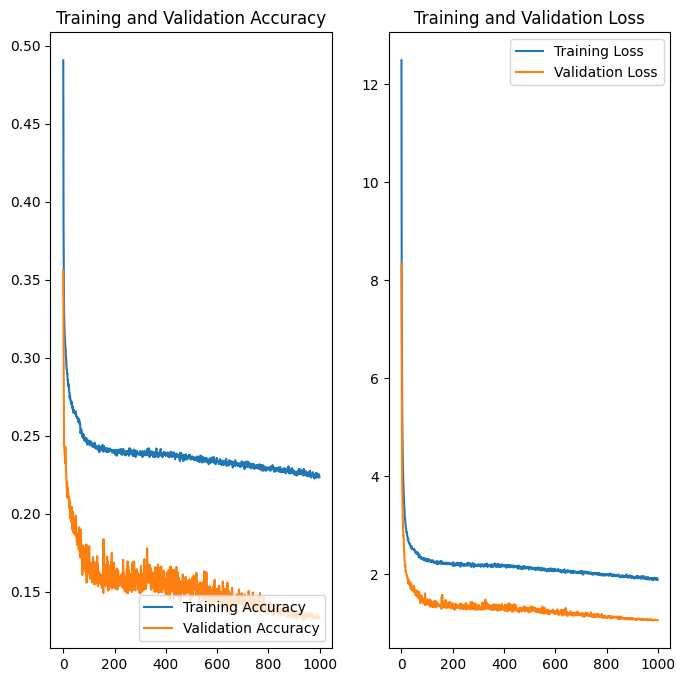

In [48]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

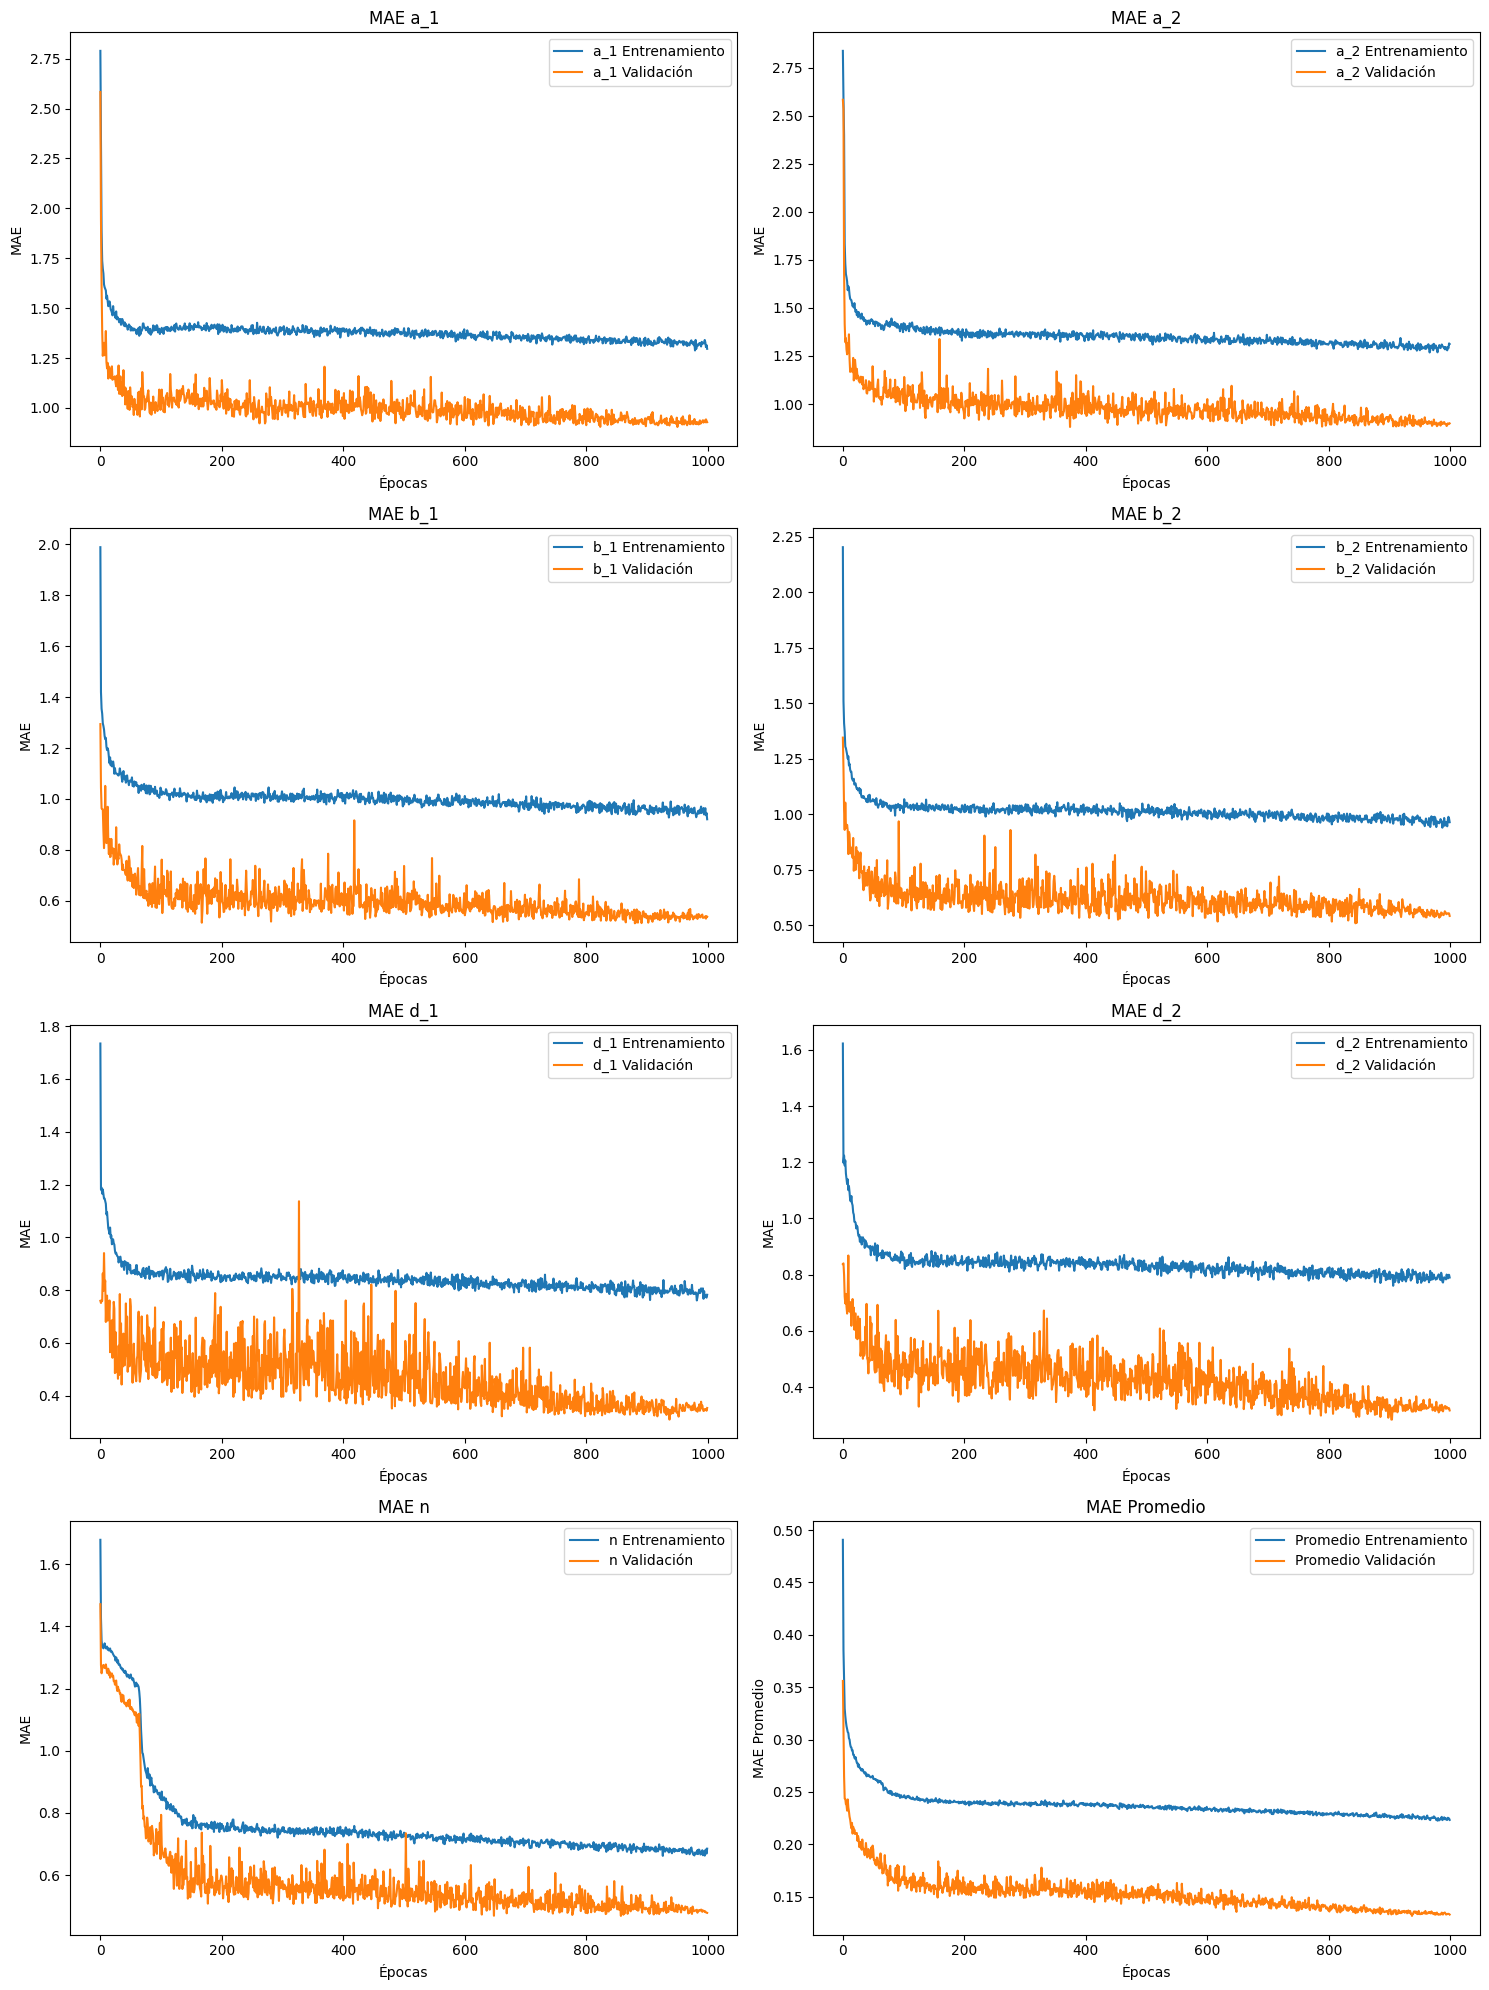

In [49]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [50]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

32/32 [==============================] - 0s 900us/step - loss: 1.0822 - a_1: 0.9412 - a_2: 0.9081 - b_1: 0.5474 - b_2: 0.5464 - d_1: 0.3675 - d_2: 0.3203 - n: 0.4982 - mean_metric: 0.1356


In [51]:
predictions = model.predict(campvectest)

32/32 [==============================] - 0s 643us/step


In [52]:
print(coefcampvectest[0,:])
print(predictions[0,:])
from sklearn.metrics import mean_absolute_error
print(np.sum(coefcampvectest, axis=-1))

mae1 = mean_absolute_error(coefcampvectest[0,:], predictions[0,:])
mae1

[ 7  2 10  1 10  0  1]
[8.011473  1.4832914 9.0497875 1.0281194 9.305048  0.6046119 1.1889946]
[31 32 28 49 25 38 26 42 31 27 24 18 37 33 38 30 24 36 37 38 36 33 20 37
 24 35 39 26 22 26 39 26 38 42 17 23 26 25 36 24 42 34 42 29 38 28 41 30
 34 35 42 16 26 28 40 28 32 40 28 35 28 38 34 32 42 39 38 29 33 38 34 30
 32 39 32 27 31 38 22 36 29 30 35 32 43 32 29 30 41 22 23 47 31 26 34 19
 29 42 30 22 33 38 25 29 36 41 34 40 32 35 40 39 31 38 21 37 43 40 30 41
 31 29 40 31 34 36 54 26 39 29 50 26 47 33 44 11 47 27 33 18 32 43 36 34
 30 34 38 46 24 32 21 48 41 44 42 40 35 29 34 31 33 28 37 30 29 38 35 33
 32 25 38 35 25 27 21 28 38 40 23 38 34 22 42 37 33 20 40 22 35 34 24 33
 37 31 35 31 28 23 36 34 40 25 30 31 34 39 26 26 37 36 45 34 28 30 39 37
 37 35 33 45 31 35 37 31 38 27 35 29 23 51 20 25 31 24 37 43 27 25 27 37
 26 36 36 39 34 23 24 44 31 30 43 41 31 32 40 28 40 32 36 24 47 44 20 28
 29 35 27 30 27 37 53 43 47 46 21 20 20 31 39 28 38 26 36 41 27 30 50 33
 34 37 27 35 23 37 39 32 23 2

0.570724538394383

In [53]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvectest, predictions)

# Calcula la desviación estándar del error
error = coefcampvectest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 0.5897139358052187, Desviación estándar del error: 0.9485749448898805, Error absoluto máximo: 6.988930702209473


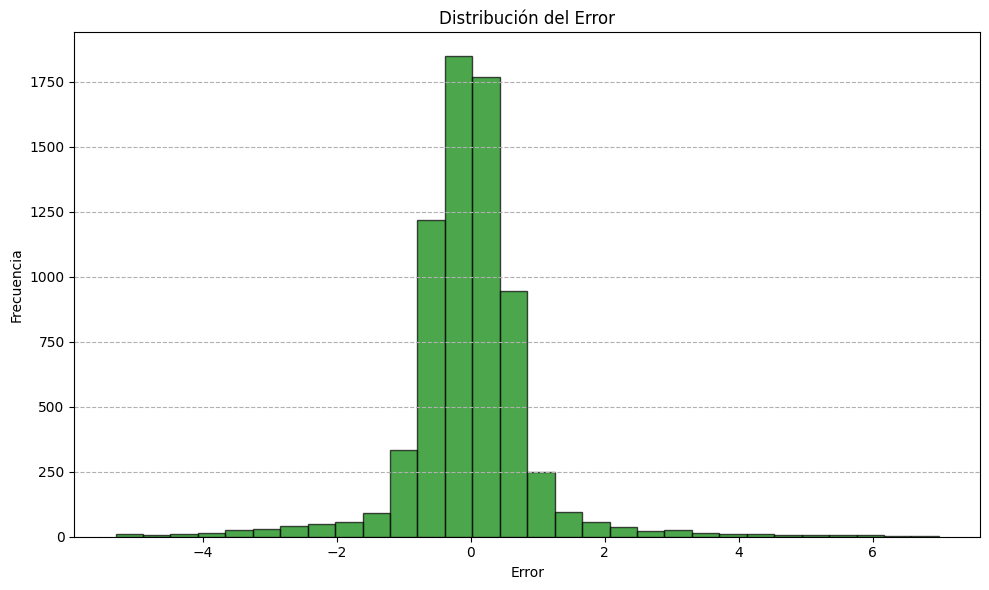

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [56]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefcampvectest - predictions)

# Calcula el error para cada dato
error = coefcampvectest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefcampvectest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.1406211505237972
Desviación estándar del error relativo: 0.052009070089793594
Error absoluto máximo relativo: 0.3541288495063782


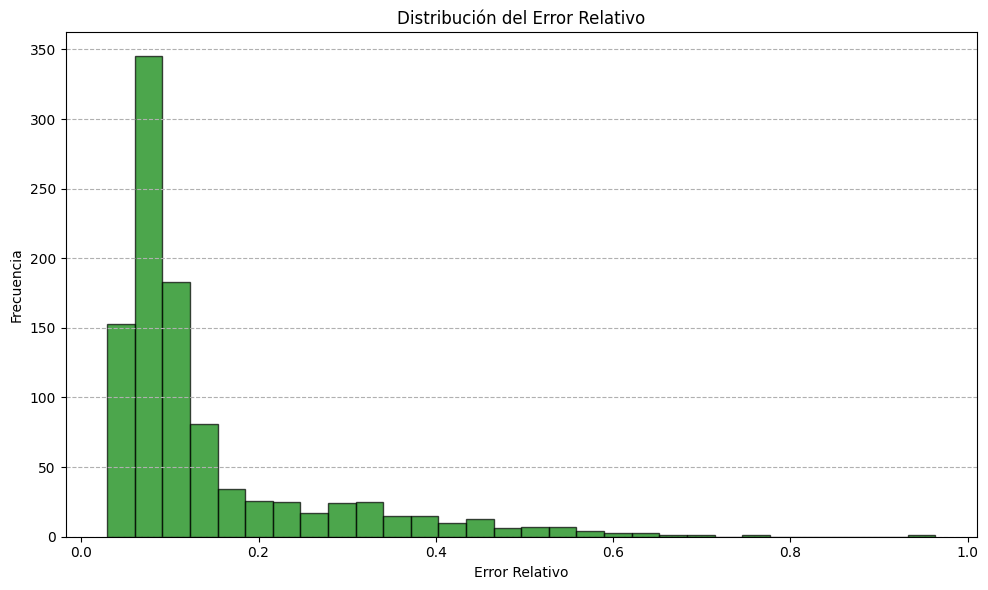

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos Accuracy y Loss

In [58]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 20,50/historycampvec20.csv', index=False)

# Guardamos el modelo

In [59]:
path_to_save = '../../../Modelos/Modelos 20,50/'

In [60]:
model.save(path_to_save + '/campovectorial20.h5')

# Importamos el modelo

In [61]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [62]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [64]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)

new_model = keras.models.load_model('../../../Modelos/Modelos 20,50/campovectorial20.h5', custom_objects= custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [78]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1 = np.linspace(x_range_neg, x_range_pos, 20)
    y2 = np.linspace(y_range_neg, y_range_pos, 20)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)
    contador = contador+1
    print(contador)
    
campvec = np.array(campvec)
coef = np.array(coef)

--------------------------------------------
[8, 9, 10, 1, 4, 9, 2]
1


In [79]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [80]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 12ms/step
[[9. 9. 9. 1. 4. 9. 2.]]


## Encontramos puntos de equilibrio datos reales

In [81]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b2
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(4.4505816565232506, 0.15917029600185498)


## Graficamos con los coeficientes reales

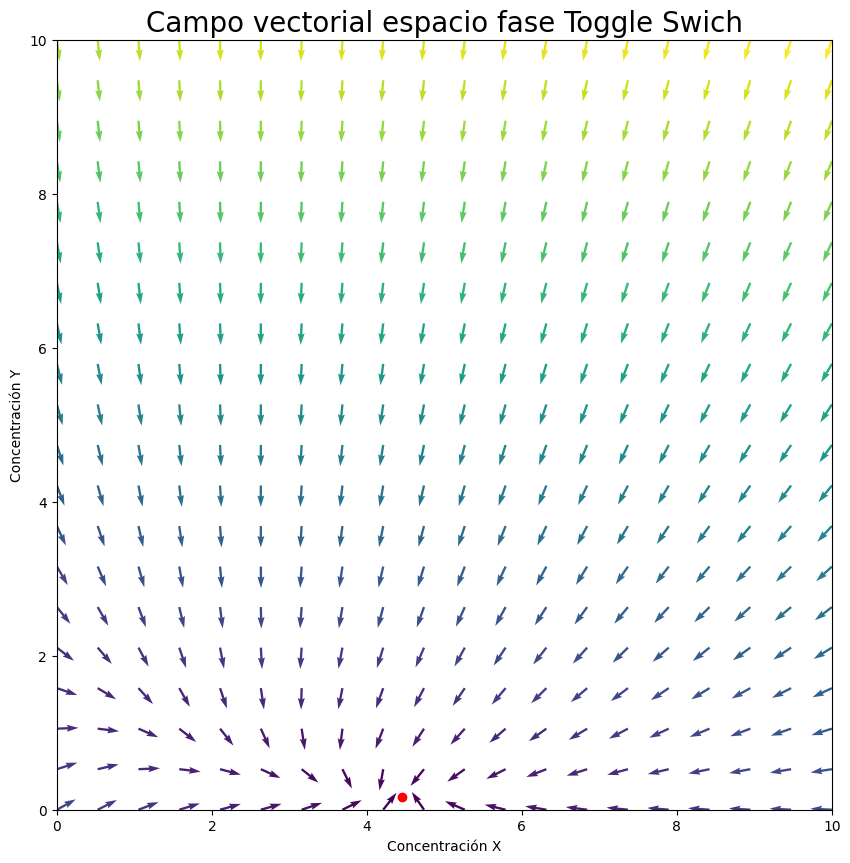

In [82]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]

y1 = np.linspace(0, 10, 20)
y2 = np.linspace(0, 10, 20)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')
plt.show()

## Encontramos puntos de equilibro datos predecidos

In [83]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b2pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(4.444316400830921, 0.15929935767788453)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

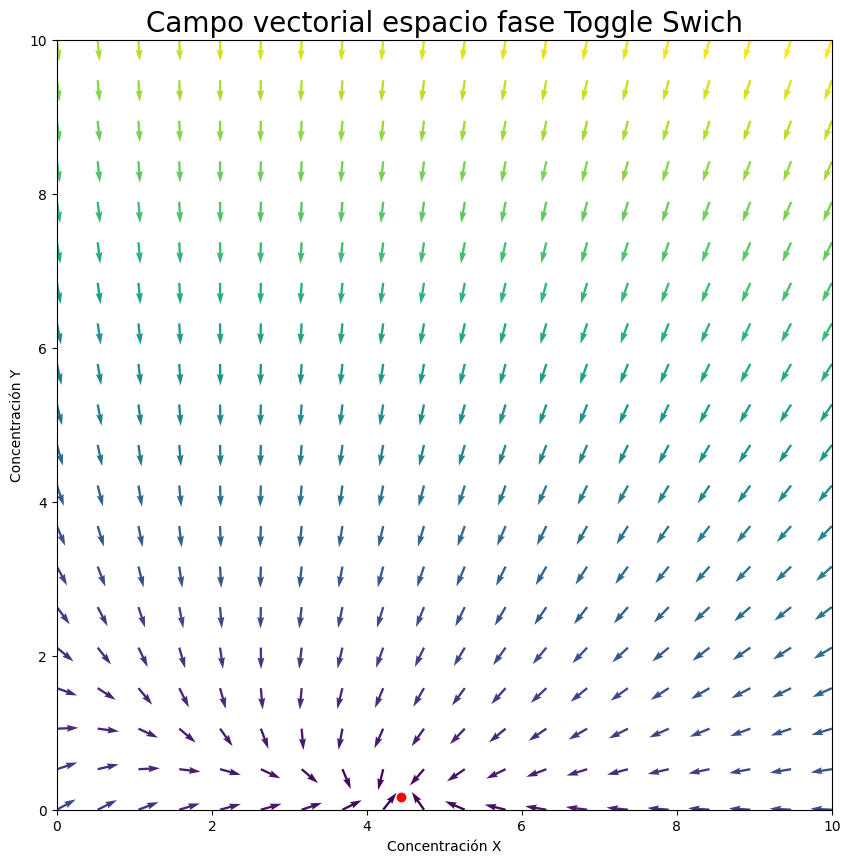

In [84]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b2pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 20)
y2pred = np.linspace(y_range_neg, y_range_pos, 20)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

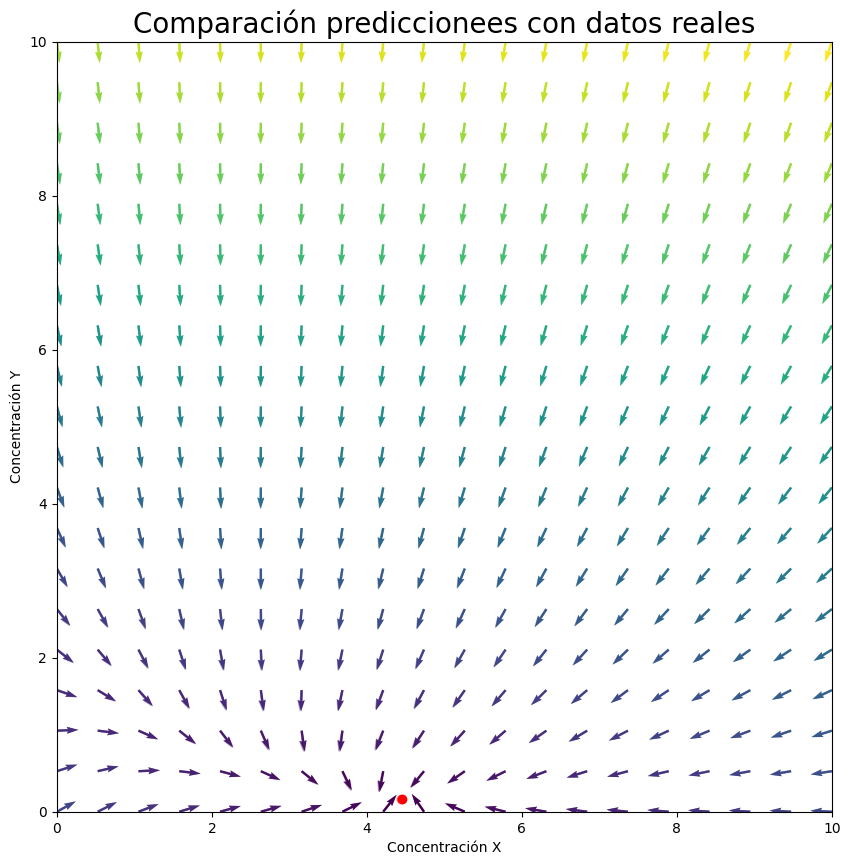

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Comparación prediccionees con datos reales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

2.0310726036721896


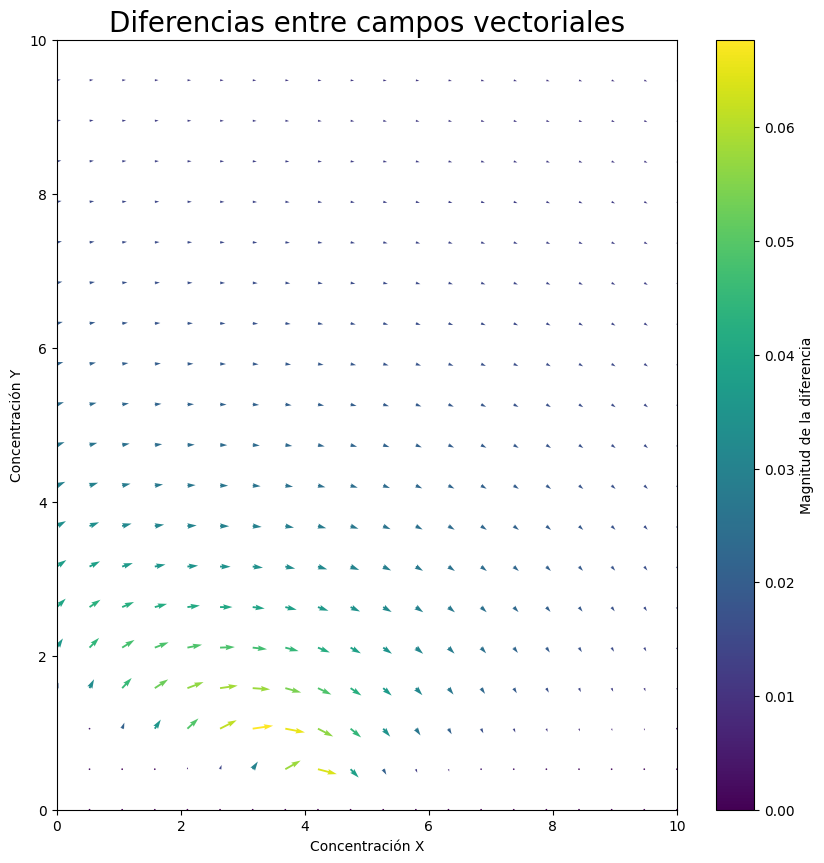

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

## Errores relativos

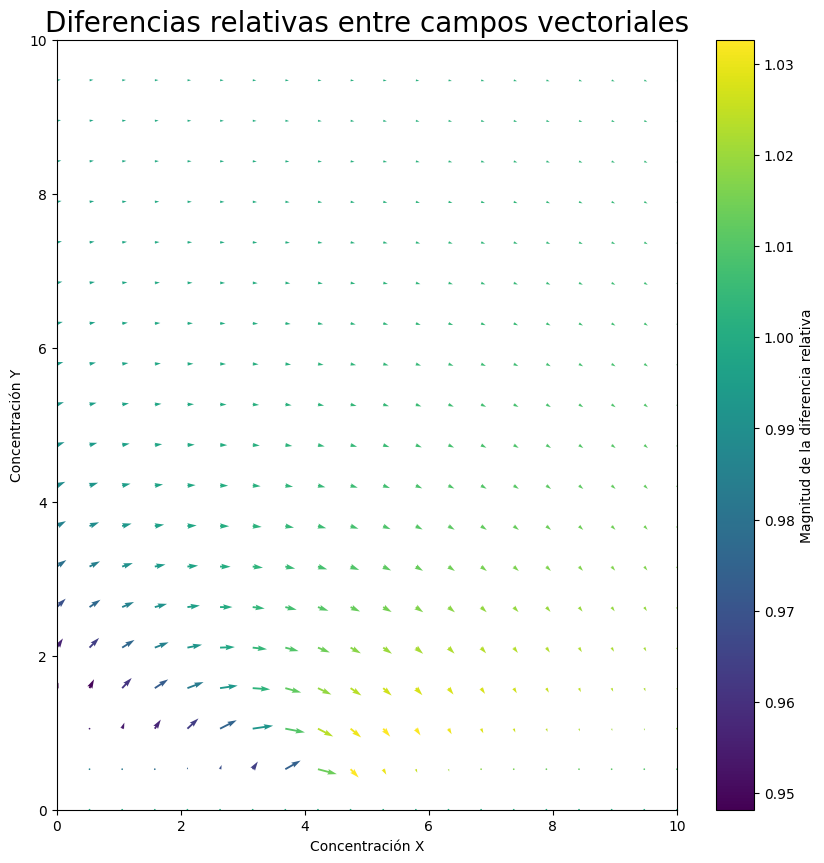

In [87]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [88]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 1.0326134791146624
El valor de u1 en el error relativo máximo es: -7.257625008645132
El valor de u1pred en el error relativo máximo es: -7.783249187357352
El valor de v1 en el error relativo máximo es: -8.160104440233873
El valor de v1pred en el error relativo máximo es: -8.160104440233873


In [89]:
# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u, v) + epsilon
M_diff = np.hypot(u_diff, v_diff)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

# Aplicamos el filtro para la diferencia relativa mayor a 0.05
mask = M_diff_rel > 0.05

# Calculamos el porcentaje de puntos que cumplen con la condición
porcentaje = np.mean(mask) * 100

print(f"El porcentaje de puntos cuyo error relativo es mayor a 0.05 es {porcentaje:.2f}%")

El porcentaje de puntos cuyo error relativo es mayor a 0.05 es 2.75%


## Simulamos 10,000 veces

In [90]:
import numpy as np
import random
from scipy.optimize import fsolve

# Listas para almacenar los resultados
porcentajes = []

# Repetimos el proceso 10 veces
for repetir in range(10000):
    campvec = []
    coef = []
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1 = np.linspace(x_range_neg, x_range_pos, 20)
    y2 = np.linspace(y_range_neg, y_range_pos, 20)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
#    print(coef1)
    
    campvec = np.array(campvec)

    
    campvecnone = campvec[None, :]
    campvecnone = np.transpose(campvecnone, (0,2,3,1))
    
    new_predictions = new_model.predict(campvecnone)
    new_predictions = np.round(new_predictions)
    new_predictions = np.clip(new_predictions, 0, None)
#    print(new_predictions)
    
    
    a1pred = new_predictions[0,0]
    a2pred = new_predictions[0,1]
    b1pred = new_predictions[0,2]
    b2pred = new_predictions[0,3]
    d1pred = new_predictions[0,4]
    d2pred = new_predictions[0,5]
    npred = new_predictions[0,6]
    
    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
        dY_dt = a2pred/(1+X**npred)-d2pred*Y+b2pred

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1pred = np.linspace(x_range_neg, x_range_pos, 20)
    y2pred = np.linspace(y_range_neg, y_range_pos, 20)

    Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
    t1 = 0

    upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

    NI, NJ = Y1.shape

    u1pred, v1pred = f(t1, [Y1, Y2])
    upred, vpred = f(t1, [Y1, Y2])
    Mpred = (np.hypot(upred, vpred))
    upred /= Mpred
    vpred /= Mpred

 # Calculamos las diferencias
    u_diff = u - upred
    v_diff = v - vpred

    # Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
    epsilon = 1e-7

    # Calculamos la magnitud del vector original y de la diferencia
    M_orig = np.hypot(u, v) + epsilon
    M_diff = np.hypot(u_diff, v_diff)

    # Calculamos la diferencia relativa
    M_diff_rel = M_diff / M_orig

    # Aplicamos el filtro para la diferencia relativa mayor a 0.05
    mask = M_diff_rel > 0.05

    # Calculamos el porcentaje de puntos que cumplen con la condición
    porcentaje = np.mean(mask) * 100

    # Almacenamos el resultado en la lista
    porcentajes.append(porcentaje)

    print(f"El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración {repetir+1} es {porcentaje:.2f}%")

# Muestra todos los porcentajes al final
print("Porcentajes para las 10 iteraciones:", porcentajes)

# Calcula y muestra el promedio de los porcentajes
promedio = np.mean(porcentajes)
print(f"El promedio de los porcentajes es {promedio:.2f}%")


--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 1 es 97.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 2 es 96.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 3 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 4 es 96.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 5 es 81.25%
--------------------------------------------
1/1 [=========================

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 45 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 46 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 47 es 36.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 48 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 49 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 89 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 90 es 77.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 91 es 91.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 92 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 93 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 133 es 93.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 134 es 93.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 135 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 136 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 137 es 92.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 177 es 90.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 178 es 96.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 179 es 91.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 180 es 96.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 181 es 97.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 221 es 98.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 222 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 223 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 224 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 225 es 96.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 265 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 266 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 9ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 267 es 95.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 268 es 90.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 269 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 309 es 97.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 310 es 95.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 311 es 87.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 312 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 313 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcenta

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 353 es 93.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 354 es 95.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 355 es 98.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 356 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 357 es 93.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 397 es 93.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 398 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 399 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 400 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 401 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 441 es 93.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 442 es 90.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 443 es 91.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 444 es 97.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 445 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 485 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 486 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 487 es 97.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 488 es 84.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 489 es 98.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 529 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 530 es 93.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 531 es 80.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 532 es 97.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 533 es 71.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 573 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 574 es 91.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 575 es 55.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 576 es 98.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 577 es 94.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 617 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 618 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 619 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 620 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 621 es 99.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcenta

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 661 es 96.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 662 es 85.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 663 es 93.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 664 es 94.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 665 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 705 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 706 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 707 es 92.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 708 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 709 es 99.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcenta

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 749 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 750 es 62.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 751 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 752 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 753 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcenta

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 793 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 794 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 795 es 95.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 796 es 98.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 797 es 90.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcenta

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 837 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 838 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 839 es 87.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 840 es 98.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 841 es 83.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 881 es 93.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 882 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 9ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 883 es 84.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 884 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 885 es 83.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 925 es 81.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 926 es 99.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 927 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 928 es 95.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 929 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 969 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 970 es 93.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 971 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 972 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 973 es 95.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcenta

KeyboardInterrupt: 